This notebook was used for all analyses reported in:

> Dubois, J., Galdi, P., Paul, L.K. and Adolphs, R. A distributed brain network predicts general intelligence from resting-state human neuroimaging data. Under review.

Please cite the work appropriately if you re-use (parts of) this code for your own research.

The code is provided as is, for documentation purposes. 
It was run on a HPC cluster with CentOS release 6.3, linux kernel 2.6.32-279.el6.x86_64

Questions can be addressed to Julien Dubois (jcrdubois@gmail.com)

# Load libraries & helper functions

In [1]:
from HCP_helpers import *
%load_ext rpy2.ipython
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'

HCP_helpers.py:57: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  from nilearn.signal import clean
/hpc/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  if __name__ == '__main__':


In [2]:
%%R 
library(ggplot2)
library(psych)
library(lavaan)
library(Hmisc)
library(corrplot)
library(semPlot)
library(colorRamps)
# Helpers functions
# compute Comparative Fit Index for a factor analysis 
CFI <-function(x){
    return((1-((x$STATISTIC-x$dof))/(x$null.chisq-x$null.dof)))
}
# compute Comparative Fit Index for a bifactor analysis 
CFI_biv <-function(x){
    return((1-((x$stats$STATISTIC-x$stats$dof))/(x$stats$null.chisq-x$stats$null.dof)))
}
# compute implied matrix for a factor analysis
impliedMatrix<-function(x){
    if (dim(x$loadings)[2]==1) {
        imp      <- x$loadings %*% t(x$loadings) 
    } else {
       imp      <- x$loadings %*% x$Phi %*% t(x$loadings) 
    }
    diag(imp)<- diag(imp) + x$uniquenesses
    return(imp)
}
# compute implied matrix for a bifactor analysis
impliedMatrix_biv<-function(x){
    Gloadings     <- x$schmid$sl[,1]
    Floadings     <- x$schmid$sl[,2:(ncol(x$schmid$sl)-3)]
    uniquenesses  <- x$schmid$sl[,ncol(x$schmid$sl)-1]
    imp           <- Gloadings %*% t(Gloadings) + Floadings %*% t(Floadings)
    diag(imp)     <- diag(imp) + uniquenesses
    return(imp)
}

/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Need help? Try the ggplot2 mailing list:
http://groups.google.com/group/ggplot2.

  warnings.warn(x, RRuntimeWarning)
/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘psych’


  warnings.warn(x, RRuntimeWarning)
/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


  warnings.warn(x, RRuntimeWarning)
/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: This is lavaan 0.5-23.1097

  warnings.warn(x, RRuntimeWarning)
/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: lavaan is BETA software! Please report any bugs.

  warnings.warn(x, RRuntimeWarn

# Set parameters

In [3]:
# should figures be saved as files
exportFigs = False

In [4]:
# config is a global variable used by several functions
# Where does the HCP data live?
config.DATADIR                 = '/scratch/duboisjx/data/HCP/MRI'
# Which release should subjects be selected from?
config.release                 = 'all+MEG2'
# Which resting-state denoising pipeline should be used for Task and for Rest?
# A replicates Finn et al Nature Neuroscience 2015 as closely as possible
config.pipelineName            = 'A'

# list available runs
fmriRuns                       = ['rfMRI_REST1_LR','rfMRI_REST1_RL',
                                  'rfMRI_REST2_LR','rfMRI_REST2_RL',
                                  'tfMRI_EMOTION_LR','tfMRI_EMOTION_RL',
                                  'tfMRI_GAMBLING_LR','tfMRI_GAMBLING_RL',
                                  'tfMRI_LANGUAGE_LR','tfMRI_LANGUAGE_RL',
                                  'tfMRI_MOTOR_LR','tfMRI_MOTOR_RL',
                                  'tfMRI_RELATIONAL_LR','tfMRI_RELATIONAL_RL',
                                  'tfMRI_SOCIAL_LR','tfMRI_SOCIAL_RL',
                                  'tfMRI_WM_LR','tfMRI_WM_RL']

# which file to use for the functional data?
#the code #fMRIrun# will be replaced by the appropriate run
config.fmriFileTemplate        = '#fMRIrun#_Atlas_MSMAll.dtseries.nii'
## do not alter the following lines ##
##>>>>>>>>
tmp = config.fmriFileTemplate.split('.')
if tmp[1]=='nii':
    config.isCifti = False
elif tmp[1]=='dtseries':
    config.isCifti = True
else:
    print 'unknown file extension'
##<<<<<<<<
# parcellation for FC matrix
config.parcellationName        = 'Glasser' #used for easy reference
config.parcellationFile        = '/scratch/duboisjx/data/parcellations/Glasser2016/Parcels.dlabel.nii'
config.nParcels                = 360
# where are the .csv files with subject scores and info?
# unrestricted
config.behavFile               = '/scratch/duboisjx/data/HCP/neuropsych/unrestricted_luckydjuju_6_7_2017_0_44_41.csv'
# RESTRICTED: needed for age, handedness, family structure,...
config.RbehavFile              = '/scratch/duboisjx/data/HCP/neuropsych/RESTRICTED_luckydjuju_8_22_2017_11_13_18.csv'
# other naming conventions
config.melodicFolder           = op.join('#fMRIrun#_hp2000.ica','filtered_func_data.ica') 
config.movementRelativeRMSFile = 'Movement_RelativeRMS.txt'
config.movementRegressorsFile  = 'Movement_Regressors_dt.txt'
# it is advisable to run the analyses on a cluster with sge
config.queue        = True
parallelEnvironment = 'smp' #'openmp'
# output directory
outDir              = op.join(config.DATADIR,'Results','INTELLIGENCE_TASK+REST',config.pipelineName,config.parcellationName)
if not op.isdir(outDir):
    makedirs(outDir)
    
# if working with volumetric data: should the parcels be restricted to the gray matter mask?
if not config.isCifti:
    config.maskParcelswithGM       = False
    if config.maskParcelswithGM:
        config.parcellationName = config.parcellationName + '_GM'

motionThr = .15


# Subject selection

In [5]:
# READ CSV FILES
Udf = pd.read_csv(config.behavFile)
Rdf = pd.read_csv(config.RbehavFile)
# merge unrestricted and restricted
df = pd.merge(Udf,Rdf,how='inner')
# keep only variables of interest
df = df[['Subject','Release','Gender','Age_in_Yrs','fMRI_3T_ReconVrs',
         'FS_BrainSeg_Vol','MMSE_Score',
        'Family_ID','Father_ID','Mother_ID','Race','Ethnicity','Handedness', 
        '3T_RS-fMRI_PctCompl','3T_tMRI_PctCompl',
         'fMRI_WM_PctCompl','fMRI_Gamb_PctCompl','fMRI_Mot_PctCompl','fMRI_Lang_PctCompl','fMRI_Soc_PctCompl','fMRI_Rel_PctCompl','fMRI_Emo_PctCompl',
         'PMAT_Compl','NEO-FFI_Compl','MMSE_Compl',
        'Non-TB_Compl','VisProc_Compl','DelDisc_Compl','SCPT_Compl','IWRD_Compl','VSPLOT_Compl', 
        'NEOFAC_O','NEOFAC_C','NEOFAC_E','NEOFAC_A','NEOFAC_N',
        'NEORAW_01','NEORAW_02','NEORAW_03','NEORAW_04','NEORAW_05','NEORAW_06','NEORAW_07','NEORAW_08','NEORAW_09','NEORAW_10',
        'NEORAW_11','NEORAW_12','NEORAW_13','NEORAW_14','NEORAW_15','NEORAW_16','NEORAW_17','NEORAW_18','NEORAW_19','NEORAW_20',
        'NEORAW_21','NEORAW_22','NEORAW_23','NEORAW_24','NEORAW_25','NEORAW_26','NEORAW_27','NEORAW_28','NEORAW_29','NEORAW_30',
        'NEORAW_31','NEORAW_32','NEORAW_33','NEORAW_34','NEORAW_35','NEORAW_36','NEORAW_37','NEORAW_38','NEORAW_39','NEORAW_40',
        'NEORAW_41','NEORAW_42','NEORAW_43','NEORAW_44','NEORAW_45','NEORAW_46','NEORAW_47','NEORAW_48','NEORAW_49','NEORAW_50',
        'NEORAW_51','NEORAW_52','NEORAW_53','NEORAW_54','NEORAW_55','NEORAW_56','NEORAW_57','NEORAW_58','NEORAW_59','NEORAW_60',
        'CardSort_Unadj','Flanker_Unadj','ListSort_Unadj','PicSeq_Unadj','PicVocab_Unadj','ProcSpeed_Unadj','ReadEng_Unadj',
        'IWRD_TOT','PMAT24_A_CR','VSPLOT_TC'
        ]]
# replace labeled columns with dummies
df['Gender'].replace(['F','M'],[1,2],inplace=True)
df['fMRI_3T_ReconVrs'].replace(['r177','r177 r227','r227'],[1,2,3],inplace=True)

# RECOMPUTE PERSONALITY FACTOR SCORES
# NOT USED IN THIS ANALYSIS, BUT KEPT FOR CONSISTENCY WITH PERSONALITY PAPER SUBJECT SELECTION
scoring = [ 
    {'13':'n', '23':'r', '43':'n', #aesthetic interests
    '48':'r', '53':'n', '58':'n', #intellectual interests
    '03':'r', '08':'r', '18':'r', '38':'r', # unconventionality
    '28':'n', '33':'r'},#??
    {'05':'n', '10':'n', '15':'r', '30':'r', '55':'r', # orderliness
    '25':'n', '35':'n', '60':'n', # goal-striving
    '20':'n', '40':'n', '45':'r', '50':'n'}, # dependability
    {'07':'n', '12':'r', '37':'n', '42':'r', # positive affect
   '02':'n', '17':'n', '27':'r', '57':'r', # sociability
   '22':'n', '32':'n', '47':'n', '52':'n'}, # activity
    {'09':'r', '14':'r', '19':'n', '24':'r', '29':'r', '44':'r', '54':'r', '59':'r', #nonantagonistic orientation
   '04':'n', '34':'n', '39':'r', '49':'n'}, # prosocial orientation
    {'01':'r', '11':'n', '16':'r', '31':'r', '46':'r', # negative affect
   '06':'n', '21':'n', '26':'n', '36':'n', '41':'n', '51':'n', '56':'n'} # self-reproach
    ]
factors = ['O','C','E','A','N']
scoreL  = ['NEOFAC_O', 'NEOFAC_C', 'NEOFAC_E', 'NEOFAC_A_corr', 'NEOFAC_N']
diff     = list()
for iFac,factor in enumerate(factors):
    this       = np.zeros(df.shape[0])
    keyCtr = -1
    for key in scoring[iFac].keys():
        if scoring[iFac][key]=='n':
            df['NEORAW_'+key].replace(['SD','D','N','A','SA'],[0,1,2,3,4],inplace=True)
        else:
            df['NEORAW_'+key].replace(['SD','D','N','A','SA'],[4,3,2,1,0],inplace=True)
        this = this + df['NEORAW_'+key]
        keyCtr += 1
    df['NEOFAC_'+factor+'_calc']=this
    diff.append(np.sum(np.abs(df['NEOFAC_'+factor]-df['NEOFAC_'+factor+'_calc'])))
print 'diffO={0:d}, diffC={1:d}, diffE={2:d}, diffA={3:d}, diffN={4:d}'.format(
    np.int(diff[0]),np.int(diff[1]),np.int(diff[2]),np.int(diff[3]),np.int(diff[4]))
# correct scores
df['NEOFAC_A_corr']  = df['NEOFAC_A_calc']

# select subjects according to release
if config.release == 'Q2':
    keepSub = (df['Release'] == 'Q2') | (df['Release'] == 'Q1')
elif config.release == 'S500':
    keepSub = (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'Q2+S500':
    keepSub = (df['Release'] == 'Q2') | (df['Release'] == 'Q1') | (df['Release'] == 'Q3') | (df['Release'] == 'S500')
elif config.release == 'S900':
    keepSub = (df['Release'] == 'S900')
elif config.release == 'S1200':
    keepSub = (df['Release'] == 'S1200')
elif config.release == 'all':
    keepSub = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200'))
elif config.release == 'all+MEG2':
    keepSub = ((df['Release'] == 'Q1') | (df['Release'] == 'Q2') | (df['Release'] == 'Q3') 
           | (df['Release'] == 'S500') | (df['Release'] == 'S900') | (df['Release'] == 'S1200') 
           | (df['Release'] == 'MEG2'))
else:
    sys.exit("Invalid release code")
print 'Selected {} subjects for release {}'.format(np.sum(keepSub),config.release)

# select subjects that have completed all neuropsych
keepSub = keepSub & (
    (df['PMAT_Compl']==True) &
    (df['NEO-FFI_Compl']==True) &
    (df['MMSE_Compl']==True) &
    (df['Non-TB_Compl']==True) &
    (df['VisProc_Compl']==True) &
    (df['SCPT_Compl']==True) &
    (df['IWRD_Compl']==True) &
    (df['VSPLOT_Compl']==True)
    )
print 'Selected {} subjects with complete neuropsych data'.format(np.sum(keepSub))

# FURTHER EXCLUSIONARY CRITERIA: MISSING VALUES
keepSub    = np.logical_and(keepSub,np.logical_not(np.isnan(df['CardSort_Unadj'])))
keepSub    = np.logical_and(keepSub,np.logical_not(np.isnan(df['VSPLOT_TC'])))
keepSub    = np.logical_and(keepSub,np.logical_not(np.isnan(df['PicSeq_Unadj'])))
keepSub    = np.logical_and(keepSub,np.logical_not(np.isnan(df['NEORAW_01'])))
print 'Kept {} subjects after removing missing values'.format(np.sum(keepSub))

# COGNITIVE COMPROMISE --> MMSE <26 excluded
keepSub    = np.logical_and(keepSub,df['MMSE_Score']>=26)
print 'Kept {} subjects after MMSE<26 exclusion criterion'.format(np.sum(keepSub))

# PRUNE df 
df        = df[keepSub]
# reindex
df.index  = range(df.shape[0])

print 'Included data for FACTOR ANALYSIS: {} subjects [{} F, {:0.1f}+/-{:0.1f} range {}-{} y.o.]'.format(
    len(df),np.sum(df['Gender']==1),np.mean(df['Age_in_Yrs']),np.std(df['Age_in_Yrs']),np.min(df['Age_in_Yrs']),np.max(df['Age_in_Yrs']))

diffO=0, diffC=0, diffE=0, diffA=2682, diffN=0
Selected 1206 subjects for release all+MEG2
Selected 1188 subjects with complete neuropsych data
Kept 1183 subjects after removing missing values
Kept 1181 subjects after MMSE<26 exclusion criterion
Included data for FACTOR ANALYSIS: 1181 subjects [638 F, 28.8+/-3.7 range 22-37 y.o.]


## Exploratory factor analysis
We conducted an exploratory factor analysis (EFA), specifying the bi-factor model of intelligence -- a common factor g which loads on all test scores, and several group factors that each load on subsets of the test scores; all latent factors are orthogonal to one another -- using the psych (v1.7.8) package in R (v3.4.2). We specifically used the omega function, which conducts a factor analysis (with maximum likelihood estimation) of the data set, rotates the factors obliquely (using "oblimin" rotation), factors the resulting correlation matrix, then does a Schmid-Leiman transformation to find general factor loadings.

In [6]:
cogScores = ['PicVocab_Unadj',              # Vocabulary, Language, Crystallized, Global
             'ReadEng_Unadj',               # Reading, Language, Crystallized, Global
             'PicSeq_Unadj',                # Episodic memory, Fluid, Global
             'Flanker_Unadj',               # Executive, Fluid, Global
             'CardSort_Unadj',              # Executive, Fluid, Global
             'ProcSpeed_Unadj',             # Speed, Executive, Fluid, Global
             'PMAT24_A_CR',                 # non-verbal reasoning: Number of Correct Responses, Median Reaction Time for Correct Responses 
             'VSPLOT_TC',                   # Spatial ability: Total Number Correct, Median Reaction Time Divided by Expected Number of Clicks for Correct 
             'IWRD_TOT',                    # Verbal memory
             'ListSort_Unadj',              # Working memory, Executive, Fluid, Global
        ]
alpha = 1e-3
for score in cogScores:
    k2, p = stats.normaltest(df[score])
    print("{} normality test: p = {:g}".format(score,p))
cogdf      = df[cogScores].copy()

# standardize scores
standardize = lambda x: (x-x.mean()) / x.std() #* 15. + 100.
cogdf = cogdf.pipe(standardize)

PicVocab_Unadj normality test: p = 0.00665279
ReadEng_Unadj normality test: p = 0.0255113
PicSeq_Unadj normality test: p = 4.53695e-07
Flanker_Unadj normality test: p = 0.0232148
CardSort_Unadj normality test: p = 0.00816415
ProcSpeed_Unadj normality test: p = 5.51678e-05
PMAT24_A_CR normality test: p = 1.49829e-33
VSPLOT_TC normality test: p = 7.65555e-06
IWRD_TOT normality test: p = 4.19517e-24
ListSort_Unadj normality test: p = 0.00257388


### FIGURE 1a & SUPPLEMENTARY FIGURE 2
Show grid plot of scores: Pearson correlations below the diagonal, histograms on the diagonal, scatter plots above the diagonal.

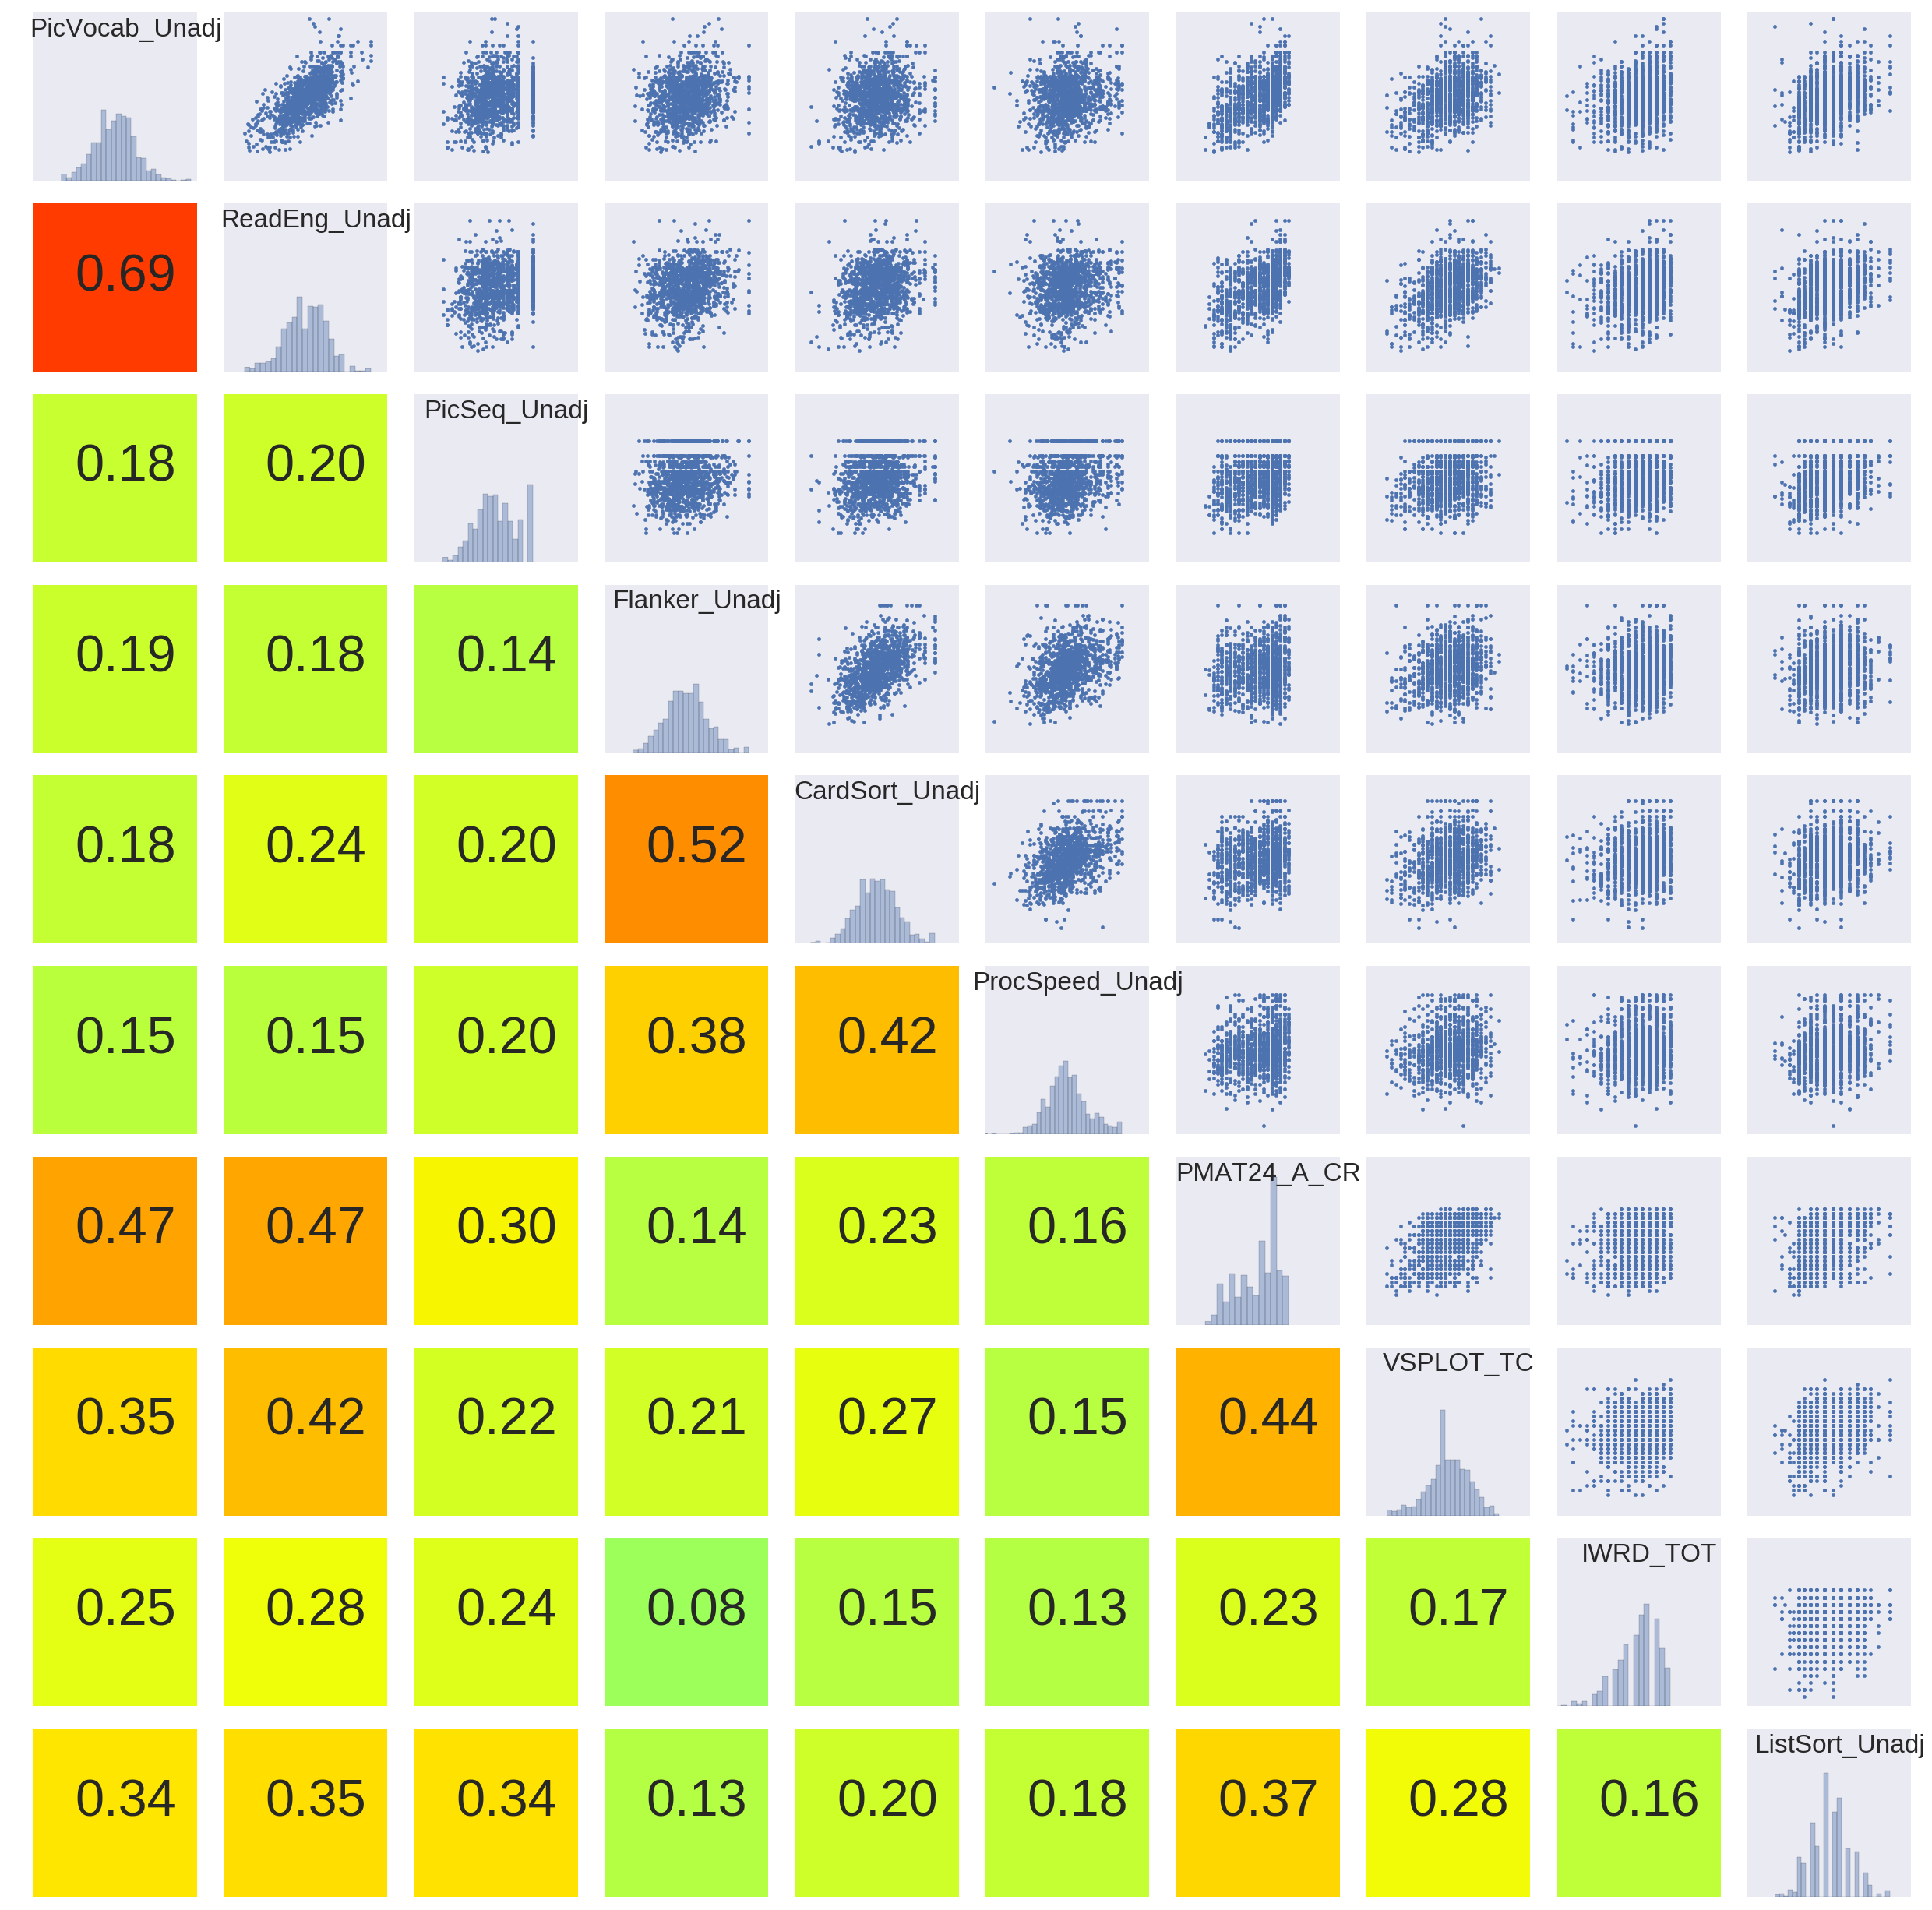

In [7]:
def corrfunc(x, y, **kws):
    cmap = matplotlib.cm.get_cmap('jet')
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.text(0.5, 0.5, "{:.2f}".format(r), size=48, ha='center', va='center')
    ax.set_axis_bgcolor(cmap((r+1)/2))
    ax.spines['left'].set_visible(False) 
    ax.spines['bottom'].set_visible(False) 
def diagfunc(x, **kws):
    ax = plt.gca()
    ylims = ax.get_ylim()
    ax.text(0.5, ylims[0]+0.9*(ylims[1]-ylims[0]), x.name, size=24, ha='center', va='center')
    ax.spines['left'].set_visible(False) 

g = sns.PairGrid(cogdf, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_diag(diagfunc)
g.map_lower(corrfunc)

lims = (-4,4)
for ax in g.axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

if exportFigs:
    plt.savefig(op.join(outDir,"testCorr.svg"), format='svg')
    
# cmap = matplotlib.cm.get_cmap('jet')
# c = np.random.random((10,10))
# sns.heatmap(c,annot=True, fmt=".2f", cmap=cmap, vmin=-1,vmax=1)
# if exportFigs:
#     plt.savefig("/scratch/duboisjx/testCorrCBAR.svg", format='svg')

In [8]:
%%R -i cogdf -o faValues,faSim,faSimR 

out = fa.parallel(cogdf,plot=F)#error.bars=T,se.bars=F,
faValues = out$fa.values
faSim    = out$fa.sim
faSimR   = out$fa.simr

Parallel analysis suggests that the number of factors =  4  and the number of components =  2 


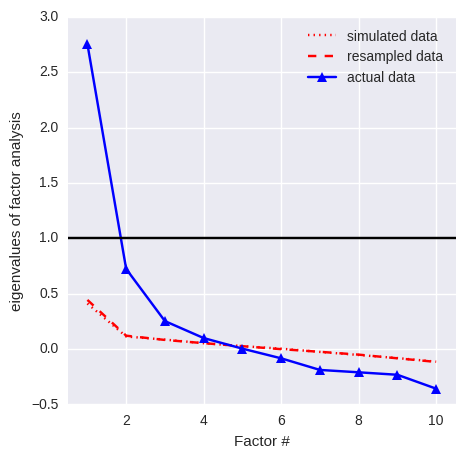

In [9]:
f,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(10)+1,faSim,'r:',label='simulated data');
ax.plot(np.arange(10)+1,faSimR,'r--',label='resampled data');
ax.plot(np.arange(10)+1,faValues,'b^-',label='actual data');
ax.axhline(y=1,linestyle='-',color='k')
plt.setp(ax,xlabel='Factor #',ylabel='eigenvalues of factor analysis',xlim=(0.5,10.5));
plt.legend()

if exportFigs:
    plt.savefig(op.join(outDir,"faParallel.svg"), format='svg')

In [10]:
%%R 
fm     <- "mle"       # use maximum likelihood estimator
rotate <- "oblimin"   # use oblimin factor rotation

fitInds <- matrix(, nrow = 2, ncol = 9)
rownames(fitInds) <- c('s1','b4')
colnames(fitInds) <- c('CFI','RMSEA','SRMR','BIC','om_h','om_s1','om_s2','om_s3','om_s4')

# observed covariance matrices
obs       <-  cov(cogdf)
lobs      <-  obs[!lower.tri(obs)]

#SINGLE FACTOR
model = 1
f1     <- fa(cogdf,nfactors=1)
imp    <-  impliedMatrix(f1)
limp   <-  imp[!lower.tri(imp)]
fitInds[model,1] <-  CFI(f1)
fitInds[model,2] <-  f1$RMSEA[1]
fitInds[model,3] <-  sqrt(mean((limp - lobs)^2))
fitInds[model,4] <-  f1$BIC

# BI-FACTOR MODEL
model = 2
b4      <- omega(cogdf,nfactors=4,fm=fm,key=NULL,flip=FALSE,
        digits=3,title="Omega",sl=TRUE,labels=NULL, plot=FALSE,
        n.obs=NA,rotate=rotate,Phi = NULL,option="equal",covar=FALSE)
imp     <-  impliedMatrix_biv(b4)
limp    <-  imp[!lower.tri(imp)]
fitInds[model,1] <-  CFI_biv(b4)
fitInds[model,2] <-  b4$schmid$RMSEA[1]
fitInds[model,3] <-  sqrt(mean((limp - lobs)^2))
fitInds[model,4] <-  b4$stats$BIC
fitInds[model,5] <-  b4$omega_h
fitInds[model,6:9] <-  b4$omega.group[-1,3]

print(fitInds,digits=3)

print(b4)

/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required namespace: GPArotation

  warnings.warn(x, RRuntimeWarning)


     CFI  RMSEA   SRMR     BIC  om_h om_s1 om_s2  om_s3 om_s4
s1 0.719 0.1398 0.0887 591.172    NA    NA    NA     NA    NA
b4 0.990 0.0311 0.0201  -0.519 0.585 0.387 0.574 0.0986 0.278
Omega 
Call: omega(m = cogdf, nfactors = 4, fm = fm, key = NULL, flip = FALSE, 
    digits = 3, title = "Omega", sl = TRUE, labels = NULL, plot = FALSE, 
    n.obs = NA, rotate = rotate, Phi = NULL, option = "equal", 
    covar = FALSE)
Alpha:                 0.78 
G.6:                   0.8 
Omega Hierarchical:    0.58 
Omega H asymptotic:    0.69 
Omega Total            0.85 

Schmid Leiman Factor loadings greater than  0.2 
                   g   F1*   F2*   F3*   F4*   h2   u2   p2
PicVocab_Unadj  0.62  0.76                   0.97 0.03 0.40
ReadEng_Unadj   0.64  0.38                   0.59 0.41 0.70
PicSeq_Unadj    0.35                    0.63 0.52 0.48 0.24
Flanker_Unadj   0.26        0.65             0.48 0.52 0.14
CardSort_Unadj  0.36        0.67             0.59 0.41 0.22
ProcSpeed_Unadj 0.23   

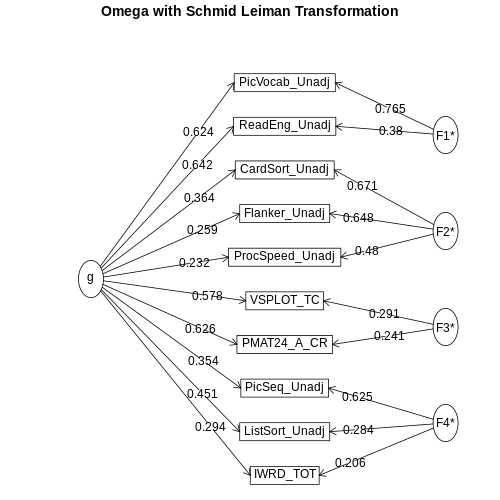

In [11]:
%%R -w 500 -h 500 -o b4Scores

diagram(b4,digits=3,cut=.2)
# export scores
b4Scores    <- factor.scores(cogdf,b4$schmid$sl[,1:5])$scores

In [12]:
%%R
#Factor labels: 
#g   = General factor; 
#spd = Processing Speed; 
#cry = Crystallized Ability; 
#vis = Visuospatial Ability; 
#mem = Memory

#biB enforces loadings of 1 for factors defined by only two observed variables
biB <- '
    #g-factor
    g   =~ CardSort_Unadj + Flanker_Unadj + ProcSpeed_Unadj + PicVocab_Unadj + ReadEng_Unadj + PMAT24_A_CR + VSPLOT_TC + IWRD_TOT + PicSeq_Unadj
    #Domain factors
    spd =~ CardSort_Unadj + Flanker_Unadj + ProcSpeed_Unadj
    cry =~ 1*PicVocab_Unadj + 1*ReadEng_Unadj
    vis =~ 1*PMAT24_A_CR    + 1*VSPLOT_TC    
    mem =~ 1*IWRD_TOT       + 1*PicSeq_Unadj
    #Domain factors are not correlated with g
    g ~~ 0*spd
    g ~~ 0*cry
    g ~~ 0*vis
    g ~~ 0*mem
    #Domain factors are not correlated with one another
    spd ~~ 0*cry
    spd ~~ 0*vis
    spd ~~ 0*mem
    cry ~~ 0*vis
    cry ~~ 0*mem
    vis ~~ 0*mem
'
mod_biB    <- cfa(biB, data=cogdf,estimator='ML')
print(mod_biB)

lavaan (0.5-23.1097) converged normally after  49 iterations

  Number of observations                          1181

  Estimator                                         ML
  Minimum Function Test Statistic               87.464
  Degrees of freedom                                21
  P-value (Chi-square)                           0.000


      cfi       tli     rmsea      srmr       aic       bic     chisq        df 
    0.974     0.955     0.052     0.032 27698.492 27820.271    87.464    21.000 


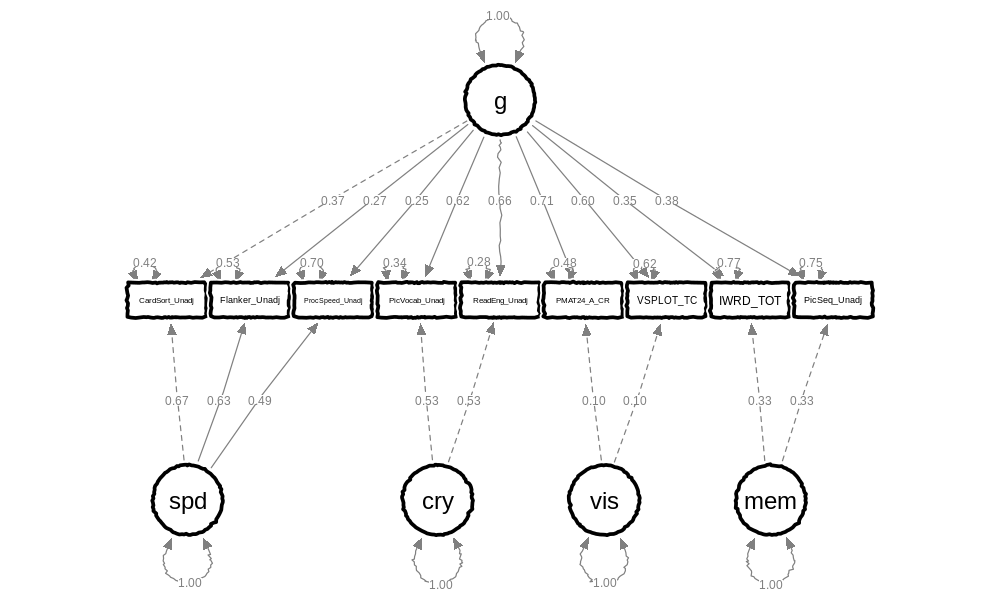

In [13]:
%%R -w 1000 -h 600 -o biScores

semPaths(mod_biB, "model", "std", bifactor = "g", layout = "tree2", exoCov = FALSE, nCharNodes=0,sizeMan = 9,sizeMan2 = 4,XKCD=TRUE)#, residuals = FALSE
print(fitMeasures(mod_biB,c("cfi","tli","rmsea","srmr","aic","bic","chisq","df")))
# factor scores
biScores    = lavPredict(mod_biB)

In [14]:
df['G']      = cogdf['CardSort_Unadj'] + cogdf['Flanker_Unadj'] + cogdf['ProcSpeed_Unadj'] + cogdf['PicVocab_Unadj'] + (
            cogdf['ReadEng_Unadj'] + cogdf['PMAT24_A_CR'] + cogdf['VSPLOT_TC'] + cogdf['IWRD_TOT'] + cogdf['PicSeq_Unadj'] + cogdf['ListSort_Unadj'])
df['g_efa']  = b4Scores[:,0]
df['g_cfa']  = biScores[:,0]

print df[['G','g_efa','g_cfa','PMAT24_A_CR']].corr()

                    G     g_efa     g_cfa  PMAT24_A_CR
G            1.000000  0.906723  0.921839     0.658134
g_efa        0.906723  1.000000  0.985092     0.788898
g_cfa        0.921839  0.985092  1.000000     0.822646
PMAT24_A_CR  0.658134  0.788898  0.822646     1.000000


# LET'S LOOK AT THE MRI DATA!

In [15]:
# use this cell to check whether some downloads failed 
# use list to filter subjects in db.humanconnectome.net, and download missing data
config.fmriRun=fmriRuns[10]
print config.fmriRun
excluded = list()
iSub=0
for subject in df['Subject']:
    if keepSub[iSub] is False:
        iSub += 1
        continue
    config.subject=str(subject)
    # RelRMSMean
    RelRMSMeanFile = op.join(buildpath(), 'Movement_RelativeRMS_mean.txt')
    if not op.isfile(RelRMSMeanFile):
        excluded.append(config.subject)
print ','.join(excluded)    

tfMRI_MOTOR_LR
100004,101208,101612,104113,106218,107119,107523,116322,120818,122519,124321,126931,128329,129432,129533,131621,132320,133221,133726,135427,136328,136530,140420,140723,141624,143527,146634,148234,152932,157235,162834,168038,175944,176744,179043,184642,186242,188246,189551,190132,190940,191639,194948,196548,197449,197651,197954,199554,200816,203721,204117,207628,208428,208630,208832,211518,212520,212924,214625,218128,230926,235128,263032,280941,341733,354439,354944,355542,368551,370740,373039,382545,384448,398964,403628,435136,446545,457045,481143,497764,531940,537952,550035,564046,569864,571043,571548,574958,577762,580347,584355,611231,620333,630134,632037,632845,646048,650746,687062,689369,696063,707244,729355,733548,743248,745555,748056,782157,816855,822850,825351,837863,876873,878574,884973,912548,915554,919158,940553,946666,959069


In [16]:
# FURTHER PRUNE SUBJECTS FOR MRI ANALYSIS
# Exclusion of subjects who did not complete all RS-fMRI
keepSub = np.logical_and((df['3T_RS-fMRI_PctCompl']==100).values,(df['3T_tMRI_PctCompl']==100).values)
print 'Kept {} subjects with complete fMRI datasets'.format(np.sum(keepSub))

# Exclusion of high-motion subjects
# exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)
RelRMSMean = np.zeros([len(df['Subject']), len(fmriRuns)],dtype=np.float32)
FDsum      = np.zeros([len(df['Subject']), len(fmriRuns)],dtype=np.float32)
iSub=0
excluded = list()
for subject in df['Subject']:
    if not keepSub[iSub]:
        iSub=iSub+1
        continue
    config.subject=str(subject)
    # RelRMSMean
    i=0
    for config.fmriRun in fmriRuns:
        RelRMSMeanFile = op.join(buildpath(), 'Movement_RelativeRMS_mean.txt')
        if op.isfile(RelRMSMeanFile):
            with open(RelRMSMeanFile,'r') as tmp:
                RelRMSMean[iSub,i] = float(tmp.read())
        else:
            keepSub[iSub]=False
            excluded.append(config.subject)
#             print 'missing Movement RMS file for {}, run {}'.format(config.subject,config.fmriRun)
#             print RelRMSMeanFile
            break
        i=i+1
    if i==len(fmriRuns): # all RelRMSMeanFile exist
        if np.any(RelRMSMean[iSub,:] > motionThr):
            keepSub[iSub]=False
            excluded.append(config.subject)
        else:
            keepSub[iSub]=True
    # total framewise displacement
    i=0
    for config.fmriRun in fmriRuns:
        FDsumFile = op.join(buildpath(), 'FD_sum.txt')
        if not op.isfile(FDsumFile):
            motionFile = op.join(buildpath(), config.movementRegressorsFile)
            if op.isfile(motionFile):
                dmotpars = np.abs(np.genfromtxt(motionFile)[:,6:]) #derivatives
                headradius=50 #50mm as in Powers et al. 2012
                disp=dmotpars.copy()
                disp[:,3:]=np.pi*headradius*2*(disp[:,3:]/360)
                thisFDsum=np.sum(np.sum(disp,1),0)
                with open(FDsumFile,'w') as tmp:
                    tmp.write(str(thisFDsum))
            else:
                break
        with open(FDsumFile,'r') as tmp:
            FDsum[iSub,i] = float(tmp.read())
        i=i+1
    iSub=iSub+1

# add RelRMSMean and FDsum to the dataframe
df['RelRMSMean_REST1']      = np.mean(RelRMSMean[:,0:2],axis=1)
df['FDsum_REST1']           = np.mean(FDsum[:,0:2],axis=1)
df['RelRMSMean_REST2']      = np.mean(RelRMSMean[:,2:4],axis=1)
df['FDsum_REST2']           = np.mean(FDsum[:,2:4],axis=1)
df['RelRMSMean_EMOTION']    = np.mean(RelRMSMean[:,4:6],axis=1)
df['FDsum_EMOTION']         = np.mean(FDsum[:,4:6],axis=1)
df['RelRMSMean_GAMBLING']   = np.mean(RelRMSMean[:,6:8],axis=1)
df['FDsum_GAMBLING']        = np.mean(FDsum[:,6:8],axis=1)
df['RelRMSMean_LANGUAGE']   = np.mean(RelRMSMean[:,8:10],axis=1)
df['FDsum_LANGUAGE']        = np.mean(FDsum[:,8:10],axis=1)
df['RelRMSMean_MOTOR']      = np.mean(RelRMSMean[:,10:12],axis=1)
df['FDsum_MOTOR']           = np.mean(FDsum[:,10:12],axis=1)
df['RelRMSMean_RELATIONAL'] = np.mean(RelRMSMean[:,12:14],axis=1)
df['FDsum_RELATIONAL']      = np.mean(FDsum[:,12:14],axis=1)
df['RelRMSMean_SOCIAL']     = np.mean(RelRMSMean[:,14:16],axis=1)
df['FDsum_SOCIAL']          = np.mean(FDsum[:,14:16],axis=1)
df['RelRMSMean_WM']         = np.mean(RelRMSMean[:,16:18],axis=1)
df['FDsum_WM']              = np.mean(FDsum[:,16:18],axis=1)

print 'Kept {} subjects with motion <{}mm'.format(np.sum(keepSub),motionThr)

df         = df[keepSub]
df.index   = range(df.shape[0])
print 'Included data for MRI analysis: {} subjects [{} F, {:0.1f}+/-{:0.1f} range {}-{} y.o.]'.format(
    len(df),np.sum(df['Gender']==1),np.mean(df['Age_in_Yrs']),np.std(df['Age_in_Yrs']),np.min(df['Age_in_Yrs']),np.max(df['Age_in_Yrs']))

Kept 945 subjects with complete fMRI datasets
Kept 736 subjects with motion <0.15mm
Included data for MRI analysis: 736 subjects [390 F, 28.6+/-3.7 range 22-36 y.o.]


/home/duboisjx/software/anaconda2/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


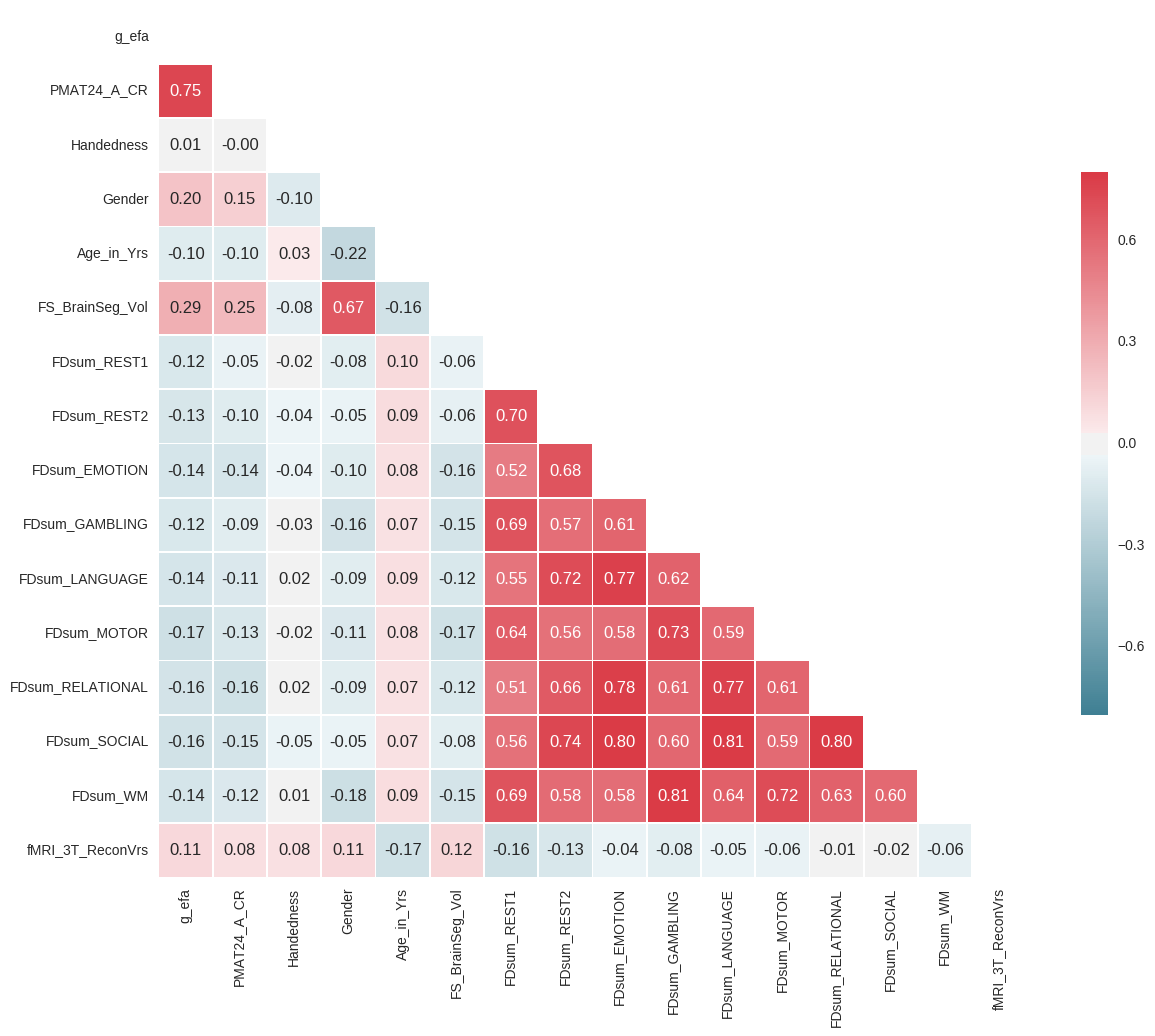

In [17]:
# look at correlation of g_efa with potentially confounding variables, and with PMAT24_A_CR
# -------------
# FIGURE 2
# -------------
scoreList  = ['g_efa',
          'PMAT24_A_CR','Handedness',
          'Gender','Age_in_Yrs','FS_BrainSeg_Vol',
          'FDsum_REST1','FDsum_REST2','FDsum_EMOTION','FDsum_GAMBLING','FDsum_LANGUAGE','FDsum_MOTOR','FDsum_RELATIONAL','FDsum_SOCIAL','FDsum_WM',
          'fMRI_3T_ReconVrs']
thisdf = df[scoreList].copy()
corr   = thisdf.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,14))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

if exportFigs:
    plt.savefig(op.join(outDir,"confounds.svg"), format='svg')

## Confound removal assessment

In [18]:
# USE MULTIPLE REGRESSION TO REMOVE EFFECTS OF CONFOUNDS
# ASSESS WHETHER THERE IS ANY CORRELATION LEFT
decon = 'decon'

if decon == 'megatrawlDecon':
    confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
elif decon == 'megatrawlDecon+IQ':
    confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
elif decon == 'decon':
    confounds=['gender','age','brainsize','motion','recon']
elif decon == 'decon+IQ':
    confounds=['gender','age','brainsize','motion','recon','PMAT24_A_CR']
elif decon == 'noDecon':
    confounds=[]

allConfounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']

# make a matrix with all confounds
conMatAll = None
for confound in allConfounds:
    if confound == 'gender':
        conVec = df['Gender']
    elif confound == 'age':
        conVec = df['Age_in_Yrs']
    elif confound == 'age^2':
        conVec = np.square(df['Age_in_Yrs'])
    elif confound == 'gender*age':
        conVec = np.multiply(df['Gender'],df['Age_in_Yrs'])
    elif confound == 'gender*age^2':
        conVec = np.multiply(df['Gender'],np.square(df['Age_in_Yrs']))
    elif confound == 'brainsize':
        conVec = df['FS_BrainSeg_Vol']
    elif confound == 'motion':
        conVec = df['FDsum_REST1']
    elif confound == 'recon':
        conVec = df['fMRI_3T_ReconVrs']
    elif confound == 'PMAT24_A_CR':
        conVec = df['PMAT24_A_CR']
    # add to conMat
    if conMatAll is None:
        conMatAll = np.array(np.ravel(conVec))
    else:
        conMatAll = np.vstack((conMatAll,conVec))
conMatAll = conMatAll.T

# make a matrix with just the confounds used
conMat = None
for confound in confounds:
    if confound == 'gender':
        conVec = df['Gender']
    elif confound == 'age':
        conVec = df['Age_in_Yrs']
    elif confound == 'age^2':
        conVec = np.square(df['Age_in_Yrs'])
    elif confound == 'gender*age':
        conVec = np.multiply(df['Gender'],df['Age_in_Yrs'])
    elif confound == 'gender*age^2':
        conVec = np.multiply(df['Gender'],np.square(df['Age_in_Yrs']))
    elif confound == 'brainsize':
        conVec = df['FS_BrainSeg_Vol']
    elif confound == 'motion':
        conVec = df['FDsum_REST1']
    elif confound == 'recon':
        conVec = df['fMRI_3T_ReconVrs']
    elif confound == 'PMAT24_A_CR':
        conVec = df['PMAT24_A_CR']
    # add to conMat
    if conMat is None:
        conMat = np.array(np.ravel(conVec))
    else:
        conMat = np.vstack((conMat,conVec))
conMat = conMat.T

# check correlations with all confounds
print allConfounds
score = 'g_efa'
# correlations before
corrBef = []
for i in range(len(allConfounds)):
    corrBef.append(stats.pearsonr(conMatAll[:,i].T,np.ravel(df[score]))[0])
print(', '.join('{:03f}'.format(k) for k in corrBef))
# regress out confounds
regr        = linear_model.LinearRegression()
regr.fit(conMat, np.ravel(df[score]))
fittedvalues = regr.predict(conMat)
deconScore   = np.ravel(df[score]) - np.ravel(fittedvalues)
# correlations after
corrAft = []
for i in range(len(allConfounds)):
    corrAft.append(stats.pearsonr(conMatAll[:,i].T,deconScore)[0])
print(', '.join('{:03f}'.format(k) for k in corrAft))

['gender', 'age', 'age^2', 'gender*age', 'gender*age^2', 'brainsize', 'motion', 'recon', 'PMAT24_A_CR']
0.202479, -0.099250, -0.103471, 0.171691, 0.121283, 0.291608, -0.120960, 0.109440, 0.746486
-0.000000, -0.000000, -0.003289, 0.006403, 0.009051, 0.000000, 0.000000, 0.000000, 0.702415


### make sure all subjects have been preprocessed

This must be run on a HPC cluster. For volume data, memory requirement is ~ 25G for each subject. 
You may want to run this cell a second time to make sure all went well (it will go through all subjects again, checking completion)

In [19]:
config.queue        = True
# the specific requirements will depend on your cluster
# here, 6 cores are requested, even though the code will only use one
# this is due to the way our specific cluster is configured
config.sgeopts      = '-l mem_free=17G -pe {} 6'.format(parallelEnvironment)

config.overwrite               = False
if config.pipelineName is 'C':
    config.useFIX              = True
else:
    config.useFIX              = False
config.scriptlist = list()

keepSub = np.zeros((len(df['Subject'])),dtype=np.bool_)
iSub    = 0
print 'Going through {} subjects, checking whether preprocessing was done'.format(df.shape[0])
printProgressBar(0, df.shape[0], prefix = 'Progress:', suffix = 'Complete', length = 50)
for subject in df['Subject']:
    config.subject = str(subject)
    iRun = 0
    for config.fmriRun in fmriRuns:
        if 'REST' in config.fmriRun:
            config.Operations   = config.operationDict[config.pipelineName]
        else:
            config.Operations   = config.operationDict[config.pipelineName+'0']
            task = config.fmriRun.split('_')[1]
            for el in config.Operations:
                if el[0] == 'TaskRegression':
                    el[2] = [task]
                    break
        keepSub[iSub] = runPipelinePar(launchSubproc=False)
        if not keepSub[iSub]:
            print config.fmriRun
            break
        iRun=iRun+1
    iSub = iSub + 1
    printProgressBar(iSub, df.shape[0], prefix = 'Progress:', suffix = 'Complete', length = 50)
print 'Keeping {}/{} subjects'.format(np.sum(keepSub),len(df['Subject']))

# prune and reindex
df        = df[keepSub]
df.index  = range(df.shape[0])

# launch array job (if there is something to do)
if len(config.scriptlist)>0:
    JobID = fnSubmitJobArrayFromJobList()
    print 'Running array job {} ({} sub jobs)'.format(JobID.split('.')[0],JobID.split('.')[1].split('-')[1].split(':')[0])
    config.joblist.append(JobID.split('.')[0])
    checkProgress(pause=60,verbose=False)

Going through 736 subjects, checking whether preprocessing was done
Progress: |##################################################| 100.0% Complete()
Keeping 736/736 subjects


###  Prepare prediction

In [20]:
# make new dataframe
newdf       = df.copy()
# print the list of subjects to a txt file for reference
outFile = op.join(outDir,'subjectList.txt');
np.savetxt(outFile, newdf['Subject'])
# dump dataframe to file
dataFile = op.join(outDir,'df.csv')
newdf.to_csv(dataFile, sep=',', encoding='utf-8')    
# make a random subject order -- for permutation testing
if not op.isfile(op.join(outDir,'permInds.txt')):
    permInds = np.vstack([np.random.permutation(range(newdf.shape[0])) for i in range(1000)])
    np.savetxt(op.join(outDir,'permInds.txt'), permInds)

In [21]:
#----------------------
# save fcMats    
#----------------------
triu_idx = np.triu_indices(config.nParcels,1)
n_edges  = triu_idx[0].shape[0]

todo = {
    'REST1':['rfMRI_REST1_LR', 'rfMRI_REST1_RL'],
    'REST2':['rfMRI_REST2_LR', 'rfMRI_REST2_RL'],
    'EMOTION':['tfMRI_EMOTION_LR', 'tfMRI_EMOTION_RL'],
    'GAMBLING':['tfMRI_GAMBLING_LR', 'tfMRI_GAMBLING_RL'],
    'LANGUAGE':['tfMRI_LANGUAGE_LR', 'tfMRI_LANGUAGE_RL'],
    'MOTOR':['tfMRI_MOTOR_LR', 'tfMRI_MOTOR_RL'],
    'RELATIONAL':['tfMRI_RELATIONAL_LR', 'tfMRI_RELATIONAL_RL'],
    'SOCIAL':['tfMRI_SOCIAL_LR', 'tfMRI_SOCIAL_RL'],
    'WM':['tfMRI_WM_LR', 'tfMRI_WM_RL'],
    'REST12':['rfMRI_REST1_LR', 'rfMRI_REST1_RL',
              'rfMRI_REST2_LR', 'rfMRI_REST2_RL'],
    'TASK':['tfMRI_EMOTION_LR', 'tfMRI_EMOTION_RL',
           'tfMRI_GAMBLING_LR', 'tfMRI_GAMBLING_RL',
           'tfMRI_LANGUAGE_LR', 'tfMRI_LANGUAGE_RL',
           'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_RL',
           'tfMRI_RELATIONAL_LR', 'tfMRI_RELATIONAL_RL',
           'tfMRI_SOCIAL_LR', 'tfMRI_SOCIAL_RL',
           'tfMRI_WM_LR', 'tfMRI_WM_RL'],
    'TASK+REST':['rfMRI_REST1_LR', 'rfMRI_REST1_RL',
               'rfMRI_REST2_LR', 'rfMRI_REST2_RL',
               'tfMRI_EMOTION_LR', 'tfMRI_EMOTION_RL',
               'tfMRI_GAMBLING_LR', 'tfMRI_GAMBLING_RL',
               'tfMRI_LANGUAGE_LR', 'tfMRI_LANGUAGE_RL',
               'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_RL',
               'tfMRI_RELATIONAL_LR', 'tfMRI_RELATIONAL_RL',
               'tfMRI_SOCIAL_LR', 'tfMRI_SOCIAL_RL',
               'tfMRI_WM_LR', 'tfMRI_WM_RL'],
       }

for key in todo.keys():
    print 'Saving fc matrices for {}'.format(key)
    fcMatFile   =  op.join(outDir,'fcMats_'+key+'.mat')
    overwrite   = False
    if (not op.isfile(fcMatFile)) or overwrite:
        fcMats_Pearson     = np.zeros((newdf.shape[0],n_edges),dtype=np.float32)
        printProgressBar(0, newdf.shape[0], prefix = 'Progress:', suffix = 'Complete', length = 50)
        iSub= 0
        for subject in newdf['Subject']:
            config.subject = str(subject)
            iRun = 0
            for config.fmriRun in todo[key]:
                if 'REST' in config.fmriRun:
                    config.Operations   = config.operationDict[config.pipelineName]
                else:
                    config.Operations   = config.operationDict[config.pipelineName+'0']
                    task = config.fmriRun.split('_')[1]
                    for el in config.Operations:
                        if el[0] == 'TaskRegression':
                            el[2] = [task]
                            break
                # retrieve the name of the denoised fMRI file
                runPipelinePar(launchSubproc=False)
                # retrieve time courses of parcels
                tsDir     = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
                rstring   = get_rcode(config.fmriFile_dn)
                tsFile    = op.join(tsDir,'allParcels_{}.txt'.format(rstring))
                ts        = np.genfromtxt(tsFile,delimiter="\t")
                # standardize
                ts -= ts.mean(axis=0)
                ts /= ts.std(axis=0)
                if iRun==0:
                    allts = ts
                else:
                    allts = np.concatenate((allts,ts),axis=0)
                iRun = iRun + 1
            # compute Pearson correlation
            allts -= allts.mean(axis=0)
            allts /= allts.std(axis=0)
            # correlation
            tmp_Pearson = np.dot(allts.T, allts) / allts.shape[0]
            fcMats_Pearson[iSub,:]      = np.arctanh(tmp_Pearson[triu_idx])
            iSub = iSub + 1
            printProgressBar(iSub, newdf.shape[0], prefix = 'Progress:', suffix = 'Complete', length = 50)
        # SAVE fcMats
        results      = {}
        results['fcMats_Pearson']     = fcMats_Pearson
        results['subjects']           = np.str(np.asarray(newdf['Subject']))
        sio.savemat(fcMatFile, results)

Saving fc matrices for WM
Saving fc matrices for TASK+REST
Saving fc matrices for RELATIONAL
Saving fc matrices for EMOTION
Saving fc matrices for TASK
Saving fc matrices for LANGUAGE
Saving fc matrices for REST2
Saving fc matrices for REST1
Saving fc matrices for GAMBLING
Saving fc matrices for MOTOR
Saving fc matrices for SOCIAL
Saving fc matrices for REST12


### Run prediction for real data (no permutations)

In [ ]:
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' # much less RAM heavy; launches an array of nCV jobs (410 here)
config.overwrite = False
decon = 'decon'
filterThr = .01
                      
fctype    = 'Pearson'
sess2plot = ['GAMBLING','WM','EMOTION','MOTOR','LANGUAGE','SOCIAL','RELATIONAL','REST1','REST2','REST12','TASK','TASK+REST']
models    = ['Finn','elnet']

SM     = 'PMAT24_A_CR'
allr   = np.zeros((len(models),len(sess2plot))) 
iModel = 0
for model in models:
    iSess  = 0
    for session in sess2plot:
        fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
        print ('{}, nsub{}, {}, {}, {}, {}'.format(
            config.release,newdf.shape[0],config.pipelineName,config.parcellationName,session,fctype))
        print '> {} thr{:.2f}'.format(model,filterThr)
        print '--------> '+ SM
        thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
            SM,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr))
        if not op.isdir(thisOutDir):
            mkdir(thisOutDir)
        if decon == 'megatrawlDecon':
            confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
        elif decon == 'megatrawlDecon+IQ':
            confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
        elif decon == 'decon':
            confounds=['gender','age','brainsize','motion','recon']
        elif decon == 'decon+IQ':
            confounds=['gender','age','brainsize','motion','recon','PMAT24_A_CR']
        elif decon == 'noDecon':
            confounds=[]
        # run prediction
        for rep in range(3):
            runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,session=session,decon=decon,fctype=fctype,
                                   outDir=thisOutDir,confounds=confounds,filterThr=filterThr,iPerm=[0])
            checkProgress(pause=10,verbose=False)
            sleep(1)
        # merge cross-validation folds, save results
        thisOutDir_ = op.join(thisOutDir,'0000')
        resFile     = op.join(thisOutDir_,'result.mat') 
        if (not op.isfile(resFile)) or config.overwrite:
            predictions_posneg = np.zeros([newdf.shape[0],1])
            predictions_pos    = np.zeros([newdf.shape[0],1])
            predictions_neg    = np.zeros([newdf.shape[0],1])
            obs                = np.zeros([newdf.shape[0],1])
            for el in np.unique(newdf['Family_ID']):
                test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                    '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                results = sio.loadmat(cvResFile) 
                if model=='Finn':
                    predictions_posneg[test_index] = results['pred_posneg'].T
                    predictions_pos[test_index]    = results['pred_pos'].T
                    predictions_neg[test_index]    = results['pred_neg'].T
                else:
                    predictions_pos[test_index]    = results['pred'].T
                obs[test_index]                  = results['score'].T

            if model=='Finn':
                r_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                r_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                r_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                results = {'obs':obs,
                           'pred_posneg':predictions_posneg, 'r_posneg':r_posneg, 'p_posneg': p_posneg,
                           'pred_pos':predictions_pos, 'r_pos':r_pos, 'p_pos': p_pos,
                           'pred_neg':predictions_neg, 'r_neg':r_neg, 'p_neg': p_neg}
            else:
                r,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                results = {'obs':obs,
                           'pred':predictions_pos, 'r':r, 'p': p}

            # save result
            sio.savemat(resFile,results)

        while not op.isfile(resFile):
            sleep(.1)

        results = sio.loadmat(resFile)
        if model=='Finn':
            print ('posneg,r={0:.3f},[pos,r={1:.3f};neg,r={2:.3f}]'.format(
                results['r_posneg'][0][0],
                results['r_pos'][0][0],
                results['r_neg'][0][0])
                  )
            allr[iModel,iSess] = results['r_pos'][0][0]
        else:
            print ('r={0:.3f}'.format(
                results['r'][0][0])
                  )
            allr[iModel,iSess] = results['r'][0][0]

        iSess += 1
    iModel += 1

all+MEG2, nsub736, A, Glasser, GAMBLING, Pearson
> Finn thr0.01
--------> PMAT24_A_CR
posneg,r=0.230,[pos,r=0.238;neg,r=0.218]
all+MEG2, nsub736, A, Glasser, WM, Pearson
> Finn thr0.01
--------> PMAT24_A_CR
posneg,r=0.259,[pos,r=0.255;neg,r=0.265]
all+MEG2, nsub736, A, Glasser, EMOTION, Pearson
> Finn thr0.01
--------> PMAT24_A_CR
posneg,r=0.149,[pos,r=0.140;neg,r=0.129]
all+MEG2, nsub736, A, Glasser, MOTOR, Pearson
> Finn thr0.01
--------> PMAT24_A_CR
posneg,r=0.180,[pos,r=0.125;neg,r=0.173]
all+MEG2, nsub736, A, Glasser, LANGUAGE, Pearson
> Finn thr0.01
--------> PMAT24_A_CR
posneg,r=0.246,[pos,r=0.243;neg,r=0.225]
all+MEG2, nsub736, A, Glasser, SOCIAL, Pearson
> Finn thr0.01
--------> PMAT24_A_CR
posneg,r=0.197,[pos,r=0.172;neg,r=0.208]
all+MEG2, nsub736, A, Glasser, RELATIONAL, Pearson
> Finn thr0.01
--------> PMAT24_A_CR
posneg,r=0.183,[pos,r=0.179;neg,r=0.142]
all+MEG2, nsub736, A, Glasser, REST1, Pearson
> Finn thr0.01
--------> PMAT24_A_CR
posneg,r=0.105,[pos,r=0.106;neg,r=0.06

In [ ]:
# plot (as in Greene et al Nat Comm 2018)
fig,ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2,sharey=True)
ax[0].bar(np.arange(len(sess2plot)),allr[0,:]);
ax[0].set_xlim([-.5,len(sess2plot)+.5]);
ax[0].set_xticks(np.arange(len(sess2plot)));ax[0].set_xticklabels(sess2plot,rotation=60);
ax[0].axvline(x=len(sess2plot)-3.1,color='r',linestyle='--');
ax[0].set_title(models[0]);
ax[1].bar(np.arange(len(sess2plot)),allr[1,:]);
ax[1].set_xlim([-.5,len(sess2plot)+.5]);
ax[1].set_xticks(np.arange(len(sess2plot)));ax[1].set_xticklabels(sess2plot,rotation=60);
ax[1].axvline(x=len(sess2plot)-3.1,color='r',linestyle='--');
ax[1].set_title(models[1]);

In [ ]:
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' # much less RAM heavy; launches an array of nCV jobs (410 here)
config.overwrite = False
decon = 'decon'
filterThr = .01
                      
fctype    = 'Pearson'
sess2plot = ['GAMBLING','WM','EMOTION','MOTOR','LANGUAGE','SOCIAL','RELATIONAL','REST1','REST2','REST12','TASK','TASK+REST']
models    = ['Finn','elnet']

SM     = 'g_efa'
allr   = np.zeros((len(models),len(sess2plot))) 
iModel = 0
for model in models:
    iSess  = 0
    for session in sess2plot:
        fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
        print ('{}, nsub{}, {}, {}, {}, {}'.format(
            config.release,newdf.shape[0],config.pipelineName,config.parcellationName,session,fctype))
        print '> {} thr{:.2f}'.format(model,filterThr)
        print '--------> '+ SM
        thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
            SM,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr))
        if not op.isdir(thisOutDir):
            mkdir(thisOutDir)
        if decon == 'megatrawlDecon':
            confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
        elif decon == 'megatrawlDecon+IQ':
            confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
        elif decon == 'decon':
            confounds=['gender','age','brainsize','motion','recon']
        elif decon == 'decon+IQ':
            confounds=['gender','age','brainsize','motion','recon','PMAT24_A_CR']
        elif decon == 'noDecon':
            confounds=[]
        # run prediction
        for rep in range(3):
            runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,session=session,decon=decon,fctype=fctype,
                                   outDir=thisOutDir,confounds=confounds,filterThr=filterThr,iPerm=[0])
            checkProgress(pause=10,verbose=False)
            sleep(1)
        # merge cross-validation folds, save results
        thisOutDir_ = op.join(thisOutDir,'0000')
        resFile     = op.join(thisOutDir_,'result.mat') 
        if (not op.isfile(resFile)) or config.overwrite:
            predictions_posneg = np.zeros([newdf.shape[0],1])
            predictions_pos    = np.zeros([newdf.shape[0],1])
            predictions_neg    = np.zeros([newdf.shape[0],1])
            obs                = np.zeros([newdf.shape[0],1])
            for el in np.unique(newdf['Family_ID']):
                test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                    '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                results = sio.loadmat(cvResFile) 
                if model=='Finn':
                    predictions_posneg[test_index] = results['pred_posneg'].T
                    predictions_pos[test_index]    = results['pred_pos'].T
                    predictions_neg[test_index]    = results['pred_neg'].T
                else:
                    predictions_pos[test_index]    = results['pred'].T
                obs[test_index]                  = results['score'].T

            if model=='Finn':
                r_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                r_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                r_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                results = {'obs':obs,
                           'pred_posneg':predictions_posneg, 'r_posneg':r_posneg, 'p_posneg': p_posneg,
                           'pred_pos':predictions_pos, 'r_pos':r_pos, 'p_pos': p_pos,
                           'pred_neg':predictions_neg, 'r_neg':r_neg, 'p_neg': p_neg}
            else:
                r,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                results = {'obs':obs,
                           'pred':predictions_pos, 'r':r, 'p': p}

            # save result
            sio.savemat(resFile,results)

        while not op.isfile(resFile):
            sleep(.1)

        results = sio.loadmat(resFile)
        if model=='Finn':
            print ('posneg,r={0:.3f},[pos,r={1:.3f};neg,r={2:.3f}]'.format(
                results['r_posneg'][0][0],
                results['r_pos'][0][0],
                results['r_neg'][0][0])
                  )
            allr[iModel,iSess] = results['r_pos'][0][0]
        else:
            print ('r={0:.3f}'.format(
                results['r'][0][0])
                  )
            allr[iModel,iSess] = results['r'][0][0]

        iSess += 1
    iModel += 1

In [ ]:
# plot (as in Greene et al Nat Comm 2018)
fig,ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2,sharey=True)
ax[0].bar(np.arange(len(sess2plot)),allr[0,:]);
ax[0].set_xlim([-.5,len(sess2plot)+.5]);
ax[0].set_xticks(np.arange(len(sess2plot)));ax[0].set_xticklabels(sess2plot,rotation=60);
ax[0].axvline(x=len(sess2plot)-3.1,color='r',linestyle='--');
ax[0].set_title(models[0]);
ax[1].bar(np.arange(len(sess2plot)),allr[1,:]);
ax[1].set_xlim([-.5,len(sess2plot)+.5]);
ax[1].set_xticks(np.arange(len(sess2plot)));ax[1].set_xticklabels(sess2plot,rotation=60);
ax[1].axvline(x=len(sess2plot)-3.1,color='r',linestyle='--');
ax[1].set_title(models[1]);

In [26]:
error()

NameError: name 'error' is not defined

### Run permutations

In [ ]:
nPerm = 1000
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False
decon = 'decon'
filterThr = .01
                            
for session in ['TASK']:#'REST12'
    fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
    for fctype in ['Pearson']:#,'invPearson']:
        print ('{}, nsub{}, {}, {}, {}, {}'.format(
            config.release,newdf.shape[0],config.pipelineName,config.parcellationName,session,fctype))
        for model in ['elnet']:#'Finn'
            print '> {} thr{:.2f}'.format(model,filterThr)
            for SM in ['PMAT24_A_CR','g_efa']:
                print '--------> '+ SM
                thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                    SM,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr))
                if not op.isdir(thisOutDir):
                    mkdir(thisOutDir)
                # REAL & PERMUTED PREDICTIONS
                jPerm = list()
                print 'Checking existing results'
                printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                for thisPerm in range(nPerm+1): 
                    thisOutDir_ = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
                    if not op.isdir(thisOutDir_):
                        mkdir(thisOutDir_)
                    resFile    = op.join(thisOutDir_,'result.mat')

                    if (not op.isfile(resFile)) or config.overwrite:
                        jPerm.append(thisPerm)
                    printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                    
                if len(jPerm)>0:
                    print 'Computing missing results'
                    if decon == 'megatrawlDecon':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
                    elif decon == 'megatrawlDecon+IQ':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'decon':
                        confounds=['gender','age','brainsize','motion','recon']
                    elif decon == 'decon+IQ':
                        confounds=['gender','age','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'noDecon':
                        confounds=[]
                    # run this thrice, just in case some jobs fail -- it happens
                    for rep in range(3):
                        runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,session=session,decon=decon,fctype=fctype,
                                           outDir=thisOutDir,confounds=confounds,filterThr=filterThr,iPerm=jPerm)
                        checkProgress(pause=10,verbose=False)
                        sleep(10)
                        
                    # merge cross-validation folds, save results
                    print 'Merging CV folds for each permutation'
                    printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
                    for thisPerm in jPerm:
                        thisOutDir_ = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
                        resFile     = op.join(thisOutDir_,'result.mat') 
                        if (not op.isfile(resFile)) or config.overwrite:
                            predictions_posneg = np.zeros([newdf.shape[0],1])
                            predictions_pos    = np.zeros([newdf.shape[0],1])
                            predictions_neg    = np.zeros([newdf.shape[0],1])
                            obs                = np.zeros([newdf.shape[0],1])
                            for el in np.unique(newdf['Family_ID']):
                                test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                                test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                                cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                                    '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                                results = sio.loadmat(cvResFile) 
                                if model=='Finn':
                                    predictions_posneg[test_index] = results['pred_posneg'].T
                                    predictions_pos[test_index]    = results['pred_pos'].T
                                    predictions_neg[test_index]    = results['pred_neg'].T
                                else:
                                    predictions_pos[test_index]    = results['pred'].T
                                obs[test_index]                    = results['score'].T

                            if model=='Finn':
                                rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                                rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                                rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                                results = {'obs':obs,
                                           'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                           'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                           'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                            else:
                                rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                                results = {'obs':obs,
                                           'pred':predictions_pos, 'rho':rho, 'p': p}
                            # save result
                            sio.savemat(resFile,results)
                        printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)

### Gather statistics and plot

In [ ]:
#------------------
# FIGURE 3
#------------------

nPerm     = 1000
session   = 'TASK'#REST12'
fctype    = 'Pearson'
model     = 'elnet'
filterThr = .01
SM        = 'g_efa' 
# SM        = 'PMAT24_A_CR'
decon     = 'decon'

thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}'.format(
                SM,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr))

outFileStats = op.join(thisOutDir,'fitStats.mat')

if not op.isfile(outFileStats):
    fitMeas      = ['Pearson r','R-squared','nRMSD']
    fitPerm      = np.empty([nPerm+1,3])
    fitPerm[:]   = np.nan
    if nPerm>0:
        printProgressBar(0, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)
    for thisPerm in range(nPerm+1):
        resDir    = op.join(thisOutDir,'{0:04d}'.format(thisPerm))
        ## MAKE SURE RESULTS.MAT EXISTS, AND HAS OBSERVED DATA SAVED
        resFile   = op.join(resDir,'result.mat')
        rePackage = False
        if (not op.isfile(resFile)) or config.overwrite:
            rePackage = True
        else:
            res       = sio.loadmat(resFile)
            if 'obs' not in res.keys():
                rePackage = True
        if rePackage: 
            # merge cross-validation folds, save results
            obs              = np.zeros([df.shape[0],1])
            pred             = np.zeros([df.shape[0],1])
            for el in np.unique(df['Family_ID']):
                test_index    = list(df.ix[df['Family_ID']==el].index)
                test_subjects = list(df.ix[df['Family_ID']==el]['Subject'])
                cvResFile = op.join(resDir,'{}.mat'.format(
                    '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                try:
                    results = sio.loadmat(cvResFile) 
                except:
                    print 'Missing prediction!'+cvResFile

                if model=='Finn':
                    pred_pos[test_index]    = results['pred_pos'].T
                    pred_neg[test_index]    = results['pred_neg'].T
                    pred_posneg[test_index] = results['pred_posneg'].T
                else:
                    pred[test_index] = results['pred'].T
                obs[test_index]      = results['score'].T

            if model=='Finn':
                rho_posneg,p_posneg   = stats.pearsonr(np.ravel(pred_posneg),np.ravel(obs))
                rho_pos,p_pos         = stats.pearsonr(np.ravel(pred_pos),np.ravel(obs))
                rho_neg,p_neg         = stats.pearsonr(np.ravel(pred_neg),np.ravel(obs))
                res = {'obs':obs,
                           'pred_posneg':pred_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                           'pred_pos':pred_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                           'pred_neg':pred_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
            else:
                rho,p   = stats.pearsonr(np.ravel(pred),np.ravel(obs))
                res = {'obs':obs,
                           'pred':pred, 'rho':rho, 'p': p}
            # save result
            sio.savemat(resFile,res)
        else:
            res       = sio.loadmat(resFile)

        if model == 'Finn': 
            pred = res['pred_pos'].reshape(-1,)
            obs  = res['obs'].reshape(-1,)
        else:
            pred = res['pred'].reshape(-1,)
            obs  = res['obs'].reshape(-1,)

        fitPerm[thisPerm,0] = stats.pearsonr(obs,pred)[0]
        # compute R^2
        fitPerm[thisPerm,1] = 1 - np.sum(np.square(obs-pred)) / np.sum(np.square(obs-np.mean(obs)))
        # compute nRMSD = sqrt(1-R^2)
        fitPerm[thisPerm,2] = np.sqrt(1 - fitPerm[thisPerm,1])
        if nPerm>0:
            printProgressBar(thisPerm, nPerm, prefix = 'Progress:', suffix = 'Complete', length = 50)               
    #save fitPerm
    res = {'fitPerm':fitPerm,'fitMeas':fitMeas}
    # save result
    sio.savemat(outFileStats,res)
else:
    res     = sio.loadmat(outFileStats)
    fitPerm = res['fitPerm']
    fitMeas = res['fitMeas']

resFile   = op.join(thisOutDir,'0000','result.mat')
res       = sio.loadmat(resFile)
if model == 'Finn': 
    pred0 = res['pred_pos'].reshape(-1,)
    obs0  = res['obs'].reshape(-1,)
else:
    pred0 = res['pred'].reshape(-1,)
    obs0  = res['obs'].reshape(-1,)

# plot three fit measures and their null distributions
nSub  = len(pred0)

# PLOT OBSERVED vs. PREDICTED (cf. Pineiro et al, Ecological Modeling 2008)
g  = sns.jointplot(pred0,obs0)
# adjust the axes
lims = [-3,3]
g.ax_joint.set_xlim(lims)
g.ax_joint.set_ylim(lims)
g.ax_joint.set_xlabel('predicted')
g.ax_joint.set_ylabel('observed')
# PLOT THE 1:1 line
line = plt.Line2D(lims,lims, c='k', linestyle='--')
g.ax_joint.add_line(line)
# FIT REGRESSION LINE
regr = linear_model.LinearRegression()
regr.fit(pred0.reshape(-1,1), obs0.reshape(-1,1))
line = plt.Line2D(np.array(lims).reshape(-1,1),regr.predict(np.array(lims).reshape(-1,1)), c='b', linestyle='-')
g.ax_joint.add_line(line)
if exportFigs:
    plt.savefig("/scratch/duboisjx/obsVSpred.svg", format='svg')

f, ax = plt.subplots(1, 3, sharey=False,figsize=(12,3))
for i,meas in enumerate(fitMeas):
    if meas=='Pearson r':
        lims = [-.5,.5]
    elif meas=='R-squared':
        lims = [-.5,.3]
    elif meas[0:5]=='nRMSD':
        lims = [0.8,1.3]
    print '{}={:.3f}'.format(meas,fitPerm[0,i])
    if nPerm>0:
        xs       = np.linspace(lims[0],lims[1],100)
        empThr05 = [np.percentile(fitPerm[1:,i],[2.5, 97.5],interpolation='midpoint')]
        empThr01 = [np.percentile(fitPerm[1:,i],[.5, 99.5],interpolation='midpoint')]
        empThr   = np.vstack((empThr05, empThr01))
        Ns, bins = np.histogram(fitPerm[1:,i], xs)
        ax[i].hist(fitPerm[1:,i], bins,color='k')
        v        = ax[i].get_ylim()
        ax[i].fill(np.hstack([empThr[1,:], empThr[1,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
        ax[i].fill(np.hstack([empThr[0,:], empThr[0,::-1]]),[v[0], v[0], v[1], v[1]],'k',alpha=0.1)
        # true
        line = plt.Line2D([fitPerm[0,i],fitPerm[0,i]],[v[0],v[1]], c='r', linestyle='-')
        ax[i].add_line(line)
        ax[i].set_xlim(lims)
        if meas in ['Pearson r','R-squared']:
            p = ((nPerm-np.where(np.argsort(np.ravel(fitPerm[:,i]))==0)[0][0])+1)/np.float(nPerm)
        else:
            p = ((np.where(np.argsort(np.ravel(fitPerm[:,i]))==0)[0][0])+1)/np.float(nPerm)
        ax[i].set_title('{}\np(1-tailed)={:.2E}'.format(fitMeas[i],p))

if exportFigs:
    plt.savefig(op.join(outDir,"predStatistics.svg"), format='svg')

## VIRTUAL LESIONS

### load and look at RS networks from Ito et al. (2017)

In [ ]:
# load brain networks from Ito et al (2017)
netLabels = np.genfromtxt(op.join(op.dirname(config.parcellationFile),'networks.csv')).astype(np.int)
# Define new network mappings with no aud1/aud2 distinction
netKey = {
    'vis':1,      # visual
    'smn':2,      # motor/tactile
    'con':3,      # cingulo-opercular
    'prem':5,     # 
    'dmn':6,      # default-mode
    'fpn':7,      # fronto-parietal 
    'aud':8,      # auditory
    'aud2':9,     # 
    'pcc':10,     #
    'dan':11,     # dorsal attention 
    'none':12,    #
    'hipp':13,    #
    'pmulti':14   #
}
# Force aud2 key to be the same as aud1
aud2_ind = np.where(netLabels==netKey['aud2'])[0]
netLabels[aud2_ind] = netKey['aud']
netKey.pop('aud2', None)
# Import network reordering
order = np.asarray(sorted(range(len(netLabels)), key=lambda k: netLabels[k]))
order.shape  = (len(order),1)
# Construct xticklabels and xticks
networks     = netKey.keys()
xticks       = {}
orderedLabels = netLabels[order]
for net in networks:
    netNum = netKey[net]
    netind = np.where(orderedLabels==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net
for net in networks:
    ind = np.sum(netLabels==netKey[net])
    print net, ind

### load an example FC mat and plot

In [ ]:
# ----------------
# Figure 4b
# ----------------
# load a fcMat
config.subject = '100307'

allFcMats = list()
for config.fmriRun in todo['REST12']:
    runPipelinePar(launchSubproc=False)
    tsDir      = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
    rstring    = get_rcode(config.fmriFile_dn)
    fcFile_dn  = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
    fcMat_dn   = (np.genfromtxt(fcFile_dn,delimiter=","))
    allFcMats.append(np.arctanh(fcMat_dn))
# average (fisher-z transformed)
fcMatREST12 = np.tanh(sum(allFcMats)/4.)

allFcMats = list()
for config.fmriRun in todo['TASK']:
    runPipelinePar(launchSubproc=False)
    tsDir      = op.join(buildpath(),config.parcellationName,config.fmriRun+config.ext)
    rstring    = get_rcode(config.fmriFile_dn)
    fcFile_dn  = op.join(tsDir,'allParcels_{}_Pearson.txt'.format(rstring))
    fcMat_dn   = (np.genfromtxt(fcFile_dn,delimiter=","))
    allFcMats.append(np.arctanh(fcMat_dn))
# average (fisher-z transformed)
fcMatTASK = np.tanh(sum(allFcMats)/4.)


# plot it, reordered
fig,ax = plt.subplots(figsize=(20,10),nrows=1,ncols=2,sharex=True,sharey=True)
ax[0].imshow(fcMatREST12[order,order.T], cmap='bwr', vmin=-.5, vmax=.5)
#plt.colorbar(fraction=0.046)
ax[0].set_title('FC Matrix for REST12',
          fontsize=16, y=1.04)
ax[0].xlabel('Regions',fontsize=12)
ax[0].ylabel('Regions', fontsize=12)
ax[0].xticks(xticks.keys(),xticks.values(), rotation=-45)
ax[0].yticks(xticks.keys(),xticks.values())
ax[0].grid(linewidth=1,color='k',linestyle='--')
ax[1].imshow(fcMatTASK[order,order.T], cmap='bwr', vmin=-.5, vmax=.5)
#plt.colorbar(fraction=0.046)
ax[1].set_title('FC Matrix for TASK',
          fontsize=16, y=1.04)
ax[1].xlabel('Regions',fontsize=12)
ax[1].ylabel('Regions', fontsize=12)
ax[1].xticks(xticks.keys(),xticks.values(), rotation=-45)
ax[1].yticks(xticks.keys(),xticks.values())
ax[1].grid(linewidth=1,color='k',linestyle='--')

plt.tight_layout()

if exportFigs:
    plt.savefig(op.join(outDir,"100307fc.svg"), format='svg')


### LESION 1 NETWORK

In [ ]:
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False
decon = 'decon'
filterThr = .01
                               
networkList       = ['dan','vis','aud','fpn','dmn','smn','con']
allRes_lesion     = np.empty((len(networkList)))

for iNet,lesion in enumerate(networkList):
    keepEdges = np.logical_not(np.logical_or(
        np.in1d(netLabels[triu_idx[0]],netKey[lesion]),
        np.in1d(netLabels[triu_idx[1]],netKey[lesion])
    ))
    print 'Removing {} edges (from the {} network)'.format(np.sum(np.logical_not(keepEdges)),lesion)
    for session in ['REST12']:#
        fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
        for fctype in ['Pearson']:#,'invPearson']:
            print ('{}, nsub{}, {}, {}, {}, {}, lesion {}'.format(
                config.release,newdf.shape[0],config.pipelineName,config.parcellationName,session,fctype, lesion))
            for model in ['elnet']:#'Finn',, 'mlr','lasso', ]:'Finn','Finn-stable','elnet-stable'
                print '> {} thr{:.2f}'.format(model,filterThr)
                for SM in ['g_efa']:
                    print '--------> '+ SM
                    thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}_lesion{}'.format(
                        SM,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr,lesion))
                    if not op.isdir(thisOutDir):
                        mkdir(thisOutDir)
                    np.savetxt(op.join(thisOutDir,'keepEdges.txt'),keepEdges)
                    # 
                    if decon == 'megatrawlDecon':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
                    elif decon == 'megatrawlDecon+IQ':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'decon':
                        confounds=['gender','age','brainsize','motion','recon']
                    elif decon == 'decon+IQ':
                        confounds=['gender','age','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'noDecon':
                        confounds=[]
                    runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,session=session,decon=decon,fctype=fctype,
                                       outDir=thisOutDir,confounds=confounds,filterThr=filterThr,iPerm=[0],
                                      keepEdgeFile=op.join(thisOutDir,'keepEdges.txt'))
                    checkProgress(pause=10,verbose=False)

                    thisOutDir_ = op.join(thisOutDir,'0000')
                    resFile     = op.join(thisOutDir_,'result.mat') 
                    if (not op.isfile(resFile)) or config.overwrite:
                        # merge cross-validation folds, save results
                        predictions_posneg = np.zeros([newdf.shape[0],1])
                        predictions_pos    = np.zeros([newdf.shape[0],1])
                        predictions_neg    = np.zeros([newdf.shape[0],1])
                        obs                = np.zeros([newdf.shape[0],1])
                        for el in np.unique(newdf['Family_ID']):
                            test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                            test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                            cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                                '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                            results = sio.loadmat(cvResFile) 
                            if model=='Finn':
                                predictions_posneg[test_index] = results['pred_posneg'].T
                                predictions_pos[test_index]    = results['pred_pos'].T
                                predictions_neg[test_index]    = results['pred_neg'].T
                            else:
                                predictions_pos[test_index]    = results['pred'].T
                            obs[test_index]                    = results['score'].T

                        if model=='Finn':
                            rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                            rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                            rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                            results = {'obs':obs,
                                       'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                       'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                       'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                        else:
                            rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                            results = {'obs':obs,
                                       'pred':predictions_pos, 'rho':rho, 'p': p}
                        # save result
                        sio.savemat(resFile,results)
                    while not op.isfile(resFile):
                        sleep(.1)

                    results = sio.loadmat(resFile)
                    if model=='Finn':
                        print ('posneg,rho={0:.3f},p={1:.5f},[pos,rho={2:.3f},p={3:.5f};neg,rho={4:.3f},p={5:.5f}]'.format(
                            results['rho_posneg'][0][0],results['p_posneg'][0][0],
                            results['rho_pos'][0][0],results['p_pos'][0][0],
                            results['rho_neg'][0][0],results['p_neg'][0][0])
                              )
                        r = results['rho_pos'][0][0]
                    else:
                        print ('rho={0:.3f},p={1:.5f}'.format(
                            results['rho'][0][0],results['p'][0][0])
                              )
                        r = results['rho'][0][0]
                    allRes_lesion[iNet] = r

### LESION ALL BUT 1 NETWORK

In [ ]:
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False
decon = 'decon'
                        
networkList       = ['dan','vis','aud','fpn','dmn','smn','con']
filterThrList     = [.1,.05,.01]
allRes_notLesion  = np.empty((len(filterThrList),len(networkList)))

for iNet,notLesion in enumerate(networkList):
    keepEdges = np.logical_and(
        np.in1d(netLabels[triu_idx[0]],netKey[notLesion]),
        np.in1d(netLabels[triu_idx[1]],netKey[notLesion])
    )
    print 'Removing {} edges (keeping only edges within the {} network ({}))'.format(
        np.sum(np.logical_not(keepEdges)),notLesion,np.sum(keepEdges))
    for session in ['REST12']:#
        fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
        for fctype in ['Pearson']:#,'invPearson']:
            print ('{}, nsub{}, {}, {}, {}, {}, notLesion {}'.format(
                config.release,newdf.shape[0],config.pipelineName,config.parcellationName,session,fctype, notLesion))
            for model in ['elnet']:#'Finn',, 'mlr','lasso', ]:'Finn','Finn-stable','elnet-stable'
                for iThr,filterThr in enumerate(filterThrList):
                    print '> {} thr{:.2f}'.format(model,filterThr)
                    for SM in ['g_efa']:
                        print '--------> '+ SM
                        thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}_notLesion{}'.format(
                            SM,config.pipelineName,config.parcellationName, session, decon, fctype, model, 
                            config.release,filterThr,notLesion))
                        if not op.isdir(thisOutDir):
                            mkdir(thisOutDir)
                        np.savetxt(op.join(thisOutDir,'keepEdges.txt'),keepEdges)
                        
                        # 
                    if decon == 'megatrawlDecon':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
                    elif decon == 'megatrawlDecon+IQ':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'decon':
                        confounds=['gender','age','brainsize','motion','recon']
                    elif decon == 'decon+IQ':
                        confounds=['gender','age','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'noDecon':
                        confounds=[]
                    runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,session=session,decon=decon,fctype=fctype,
                                       outDir=thisOutDir,confounds=confounds,filterThr=filterThr,iPerm=[0],
                                      keepEdgeFile=op.join(thisOutDir,'keepEdges.txt'))
                    checkProgress(pause=10,verbose=False)

                    thisOutDir_ = op.join(thisOutDir,'0000')
                    resFile     = op.join(thisOutDir_,'result.mat') 
                    if (not op.isfile(resFile)) or config.overwrite:
                        # merge cross-validation folds, save results
                        predictions_posneg = np.zeros([newdf.shape[0],1])
                        predictions_pos    = np.zeros([newdf.shape[0],1])
                        predictions_neg    = np.zeros([newdf.shape[0],1])
                        obs                = np.zeros([newdf.shape[0],1])
                        for el in np.unique(newdf['Family_ID']):
                            test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                            test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                            cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                                '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                            results = sio.loadmat(cvResFile) 
                            if model=='Finn':
                                predictions_posneg[test_index] = results['pred_posneg'].T
                                predictions_pos[test_index]    = results['pred_pos'].T
                                predictions_neg[test_index]    = results['pred_neg'].T
                            else:
                                predictions_pos[test_index]    = results['pred'].T
                            obs[test_index]                    = results['score'].T

                        if model=='Finn':
                            rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                            rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                            rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                            results = {'obs':obs,
                                       'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                       'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                       'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                        else:
                            rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                            results = {'obs':obs,
                                       'pred':predictions_pos, 'rho':rho, 'p': p}
                        # save result
                        sio.savemat(resFile,results)
                    while not op.isfile(resFile):
                        sleep(.1)

                    results = sio.loadmat(resFile)
                    if model=='Finn':
                        print ('posneg,rho={0:.3f},p={1:.5f},[pos,rho={2:.3f},p={3:.5f};neg,rho={4:.3f},p={5:.5f}]'.format(
                            results['rho_posneg'][0][0],results['p_posneg'][0][0],
                            results['rho_pos'][0][0],results['p_pos'][0][0],
                            results['rho_neg'][0][0],results['p_neg'][0][0])
                              )
                        r = results['rho_pos'][0][0]
                    else:
                        print ('rho={0:.3f},p={1:.5f}'.format(
                            results['rho'][0][0],results['p'][0][0])
                              )
                        r = results['rho'][0][0]
                    allRes_notLesion[iThr,iNet] = r

### LESION 2 NETWORKS

In [ ]:
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False
decon = 'decon'
filterThr = .01
                                                    
networkList       = ['dan','vis','aud','fpn','dmn','smn','con']
allRes_lesion2     = np.empty((len(networkList),len(networkList)))

for iNet1,lesion1 in enumerate(networkList):
    for iNet2,lesion2 in enumerate(networkList):
        if iNet2>iNet1:
            keepEdges = np.logical_not(np.logical_or(
                np.in1d(netLabels[triu_idx[0]],[netKey[lesion1],netKey[lesion2]]),
                np.in1d(netLabels[triu_idx[1]],[netKey[lesion1],netKey[lesion2]])
            ))
            print 'Removing {} edges (from the {} and {} networks)'.format(np.sum(np.logical_not(keepEdges)),lesion1,lesion2)
            for session in ['REST12']:#
                fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
                for fctype in ['Pearson']:#,'invPearson']:
                    print ('{}, nsub{}, {}, {}, {}, {}, lesion {}-{}'.format(
                        config.release,newdf.shape[0],config.pipelineName,config.parcellationName,session,fctype, lesion1, lesion2))
                    for model in ['elnet']:#'Finn',, 'mlr','lasso', ]:'Finn','Finn-stable','elnet-stable'
                        print '> {} thr{:.2f}'.format(model,filterThr)
                        for SM in ['g_efa']:
                            print '--------> '+ SM
                            thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}_lesion{}-{}'.format(
                                SM,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr,lesion1,lesion2))
                            if not op.isdir(thisOutDir):
                                mkdir(thisOutDir)
                            np.savetxt(op.join(thisOutDir,'keepEdges.txt'),keepEdges)
                            # 
                    if decon == 'megatrawlDecon':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
                    elif decon == 'megatrawlDecon+IQ':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'decon':
                        confounds=['gender','age','brainsize','motion','recon']
                    elif decon == 'decon+IQ':
                        confounds=['gender','age','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'noDecon':
                        confounds=[]
                    runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,session=session,decon=decon,fctype=fctype,
                                       outDir=thisOutDir,confounds=confounds,filterThr=filterThr,iPerm=[0],
                                      keepEdgeFile=op.join(thisOutDir,'keepEdges.txt'))
                    checkProgress(pause=10,verbose=False)

                    thisOutDir_ = op.join(thisOutDir,'0000')
                    resFile     = op.join(thisOutDir_,'result.mat') 
                    if (not op.isfile(resFile)) or config.overwrite:
                        # merge cross-validation folds, save results
                        predictions_posneg = np.zeros([newdf.shape[0],1])
                        predictions_pos    = np.zeros([newdf.shape[0],1])
                        predictions_neg    = np.zeros([newdf.shape[0],1])
                        obs                = np.zeros([newdf.shape[0],1])
                        for el in np.unique(newdf['Family_ID']):
                            test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                            test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                            cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                                '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                            results = sio.loadmat(cvResFile) 
                            if model=='Finn':
                                predictions_posneg[test_index] = results['pred_posneg'].T
                                predictions_pos[test_index]    = results['pred_pos'].T
                                predictions_neg[test_index]    = results['pred_neg'].T
                            else:
                                predictions_pos[test_index]    = results['pred'].T
                            obs[test_index]                    = results['score'].T

                        if model=='Finn':
                            rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                            rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                            rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                            results = {'obs':obs,
                                       'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                       'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                       'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                        else:
                            rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                            results = {'obs':obs,
                                       'pred':predictions_pos, 'rho':rho, 'p': p}
                        # save result
                        sio.savemat(resFile,results)
                    while not op.isfile(resFile):
                        sleep(.1)

                    results = sio.loadmat(resFile)
                    if model=='Finn':
                        print ('posneg,rho={0:.3f},p={1:.5f},[pos,rho={2:.3f},p={3:.5f};neg,rho={4:.3f},p={5:.5f}]'.format(
                            results['rho_posneg'][0][0],results['p_posneg'][0][0],
                            results['rho_pos'][0][0],results['p_pos'][0][0],
                            results['rho_neg'][0][0],results['p_neg'][0][0])
                              )
                        r = results['rho_pos'][0][0]
                    else:
                        print ('rho={0:.3f},p={1:.5f}'.format(
                            results['rho'][0][0],results['p'][0][0])
                              )
                        r = results['rho'][0][0]
                    allRes_lesion2[iNet1,iNet2] = r

### LESION ALL BUT 2 NETWORKS

In [ ]:
#----------------------
# predict!
#----------------------
config.queue     = True
launchSubproc    = False
config.sgeopts   = '-l mem_free=2G' 
config.overwrite = False
decon = 'decon'
filterThr = .01
                        
networkList       = ['dan','vis','aud','fpn','dmn','smn','con']
allRes_notLesion2 = np.empty((len(networkList),len(networkList)))

for iNet1,notLesion1 in enumerate(networkList):
    for iNet2,notLesion2 in enumerate(networkList):
        if iNet2>iNet1:
            keepEdges = np.logical_and(
                np.in1d(netLabels[triu_idx[0]],[netKey[notLesion1],netKey[notLesion2]]),
                np.in1d(netLabels[triu_idx[1]],[netKey[notLesion1],netKey[notLesion2]])
            )
            print 'Keeping {} edges (from the {} and {} networks)'.format(np.sum(keepEdges),notLesion1,notLesion2)
            for session in ['REST12']:#
                fcMatFile   =  op.join(outDir,'fcMats_'+session+'.mat')
                for fctype in ['Pearson']:#,'invPearson']:
                    print ('{}, nsub{}, {}, {}, {}, {}, notLesion {}-{}'.format(
                        config.release,newdf.shape[0],config.pipelineName,config.parcellationName,session,fctype, notLesion1, notLesion2))
                    for model in ['elnet']:#'Finn',, 'mlr','lasso', ]:'Finn','Finn-stable','elnet-stable'
                        print '> {} thr{:.2f}'.format(model,filterThr)
                        for SM in ['g_efa']:
                            print '--------> '+ SM
                            thisOutDir = op.join(outDir,'{}_{}_{}_{}_{}_{}_{}_{}_thr{:.2f}_notLesion{}-{}'.format(
                                SM,config.pipelineName,config.parcellationName, session, decon, fctype, model, config.release,filterThr,notLesion1,notLesion2))
                            if not op.isdir(thisOutDir):
                                mkdir(thisOutDir)
                            np.savetxt(op.join(thisOutDir,'keepEdges.txt'),keepEdges)
                            # 
                    if decon == 'megatrawlDecon':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon']
                    elif decon == 'megatrawlDecon+IQ':
                        confounds=['gender','age','age^2','gender*age','gender*age^2','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'decon':
                        confounds=['gender','age','brainsize','motion','recon']
                    elif decon == 'decon+IQ':
                        confounds=['gender','age','brainsize','motion','recon','PMAT24_A_CR']
                    elif decon == 'noDecon':
                        confounds=[]
                    runPredictionParJD(fcMatFile,dataFile,SM=SM,model=model,session=session,decon=decon,fctype=fctype,
                                       outDir=thisOutDir,confounds=confounds,filterThr=filterThr,iPerm=[0],
                                      keepEdgeFile=op.join(thisOutDir,'keepEdges.txt'))
                    checkProgress(pause=10,verbose=False)

                    thisOutDir_ = op.join(thisOutDir,'0000')
                    resFile     = op.join(thisOutDir_,'result.mat') 
                    if (not op.isfile(resFile)) or config.overwrite:
                        # merge cross-validation folds, save results
                        predictions_posneg = np.zeros([newdf.shape[0],1])
                        predictions_pos    = np.zeros([newdf.shape[0],1])
                        predictions_neg    = np.zeros([newdf.shape[0],1])
                        obs                = np.zeros([newdf.shape[0],1])
                        for el in np.unique(newdf['Family_ID']):
                            test_index    = list(newdf.ix[newdf['Family_ID']==el].index)
                            test_subjects = list(newdf.ix[newdf['Family_ID']==el]['Subject'])
                            cvResFile = op.join(thisOutDir_, '{}.mat'.format(
                                '_'.join(['%s' % test_sub for test_sub in test_subjects])))
                            results = sio.loadmat(cvResFile) 
                            if model=='Finn':
                                predictions_posneg[test_index] = results['pred_posneg'].T
                                predictions_pos[test_index]    = results['pred_pos'].T
                                predictions_neg[test_index]    = results['pred_neg'].T
                            else:
                                predictions_pos[test_index]    = results['pred'].T
                            obs[test_index]                    = results['score'].T

                        if model=='Finn':
                            rho_posneg,p_posneg   = stats.pearsonr(np.ravel(predictions_posneg),np.ravel(obs))
                            rho_pos,p_pos         = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                            rho_neg,p_neg         = stats.pearsonr(np.ravel(predictions_neg),np.ravel(obs))
                            results = {'obs':obs,
                                       'pred_posneg':predictions_posneg, 'rho_posneg':rho_posneg, 'p_posneg': p_posneg,
                                       'pred_pos':predictions_pos, 'rho_pos':rho_pos, 'p_pos': p_pos,
                                       'pred_neg':predictions_neg, 'rho_neg':rho_neg, 'p_neg': p_neg}
                        else:
                            rho,p   = stats.pearsonr(np.ravel(predictions_pos),np.ravel(obs))
                            results = {'obs':obs,
                                       'pred':predictions_pos, 'rho':rho, 'p': p}
                        # save result
                        sio.savemat(resFile,results)
                    while not op.isfile(resFile):
                        sleep(.1)

                    results = sio.loadmat(resFile)
                    if model=='Finn':
                        print ('posneg,rho={0:.3f},p={1:.5f},[pos,rho={2:.3f},p={3:.5f};neg,rho={4:.3f},p={5:.5f}]'.format(
                            results['rho_posneg'][0][0],results['p_posneg'][0][0],
                            results['rho_pos'][0][0],results['p_pos'][0][0],
                            results['rho_neg'][0][0],results['p_neg'][0][0])
                              )
                        r = results['rho_pos'][0][0]
                    else:
                        print ('rho={0:.3f},p={1:.5f}'.format(
                            results['rho'][0][0],results['p'][0][0])
                              )
                        r = results['rho'][0][0]
                    allRes_notLesion2[iNet1,iNet2] = r

### PLOT RESULTS!

In [ ]:
# ---------------
# FIGURE 4c-f
# ---------------
# SET UP 
x  = np.arange(len(networkList)) + 1
# Generate a mask for the upper triangle
mask = np.zeros_like(allRes_lesion2, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True
sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(2, 2, figsize=(12,12))
# cbar_ax = f.add_axes([.91, .5, .03, .25])
# NOT LESION 1
ax[0][0].bar(x-0.2, allRes_notLesion[0,:],width=0.2,color='g',alpha=1,align='center',label='p<0.1')
ax[0][0].bar(x, allRes_notLesion[1,:],width=0.2,color='g',alpha=.6,align='center',label='p<0.05')
ax[0][0].bar(x+0.2, allRes_notLesion[2,:],width=0.2,color='g',alpha=.2,align='center',label='p<0.01')
ax[0][0].set_title('Keeping only 1 network')
ax[0][0].set_xlim(0,8)
ax[0][0].axhline(y=0,color='k')
ax[0][0].axhline(y=.457,color='c',ls='--')
plt.setp(ax[0][0], xticks=x, xticklabels=networkList, xlabel="resting-state network",ylabel="correlation observed vs. predicted" )
ax[0][0].legend()
# NOT LESION 2
sns.heatmap(allRes_notLesion2, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.5, center=0.25,
            square=True, linewidths=.5, ax=ax[0][1], cbar=True, #cbar_ax=cbar_ax,
            xticklabels=networkList,yticklabels=networkList);
ax[0][1].set_title('Keeping only 2 networks')

# LESION 2
sns.heatmap(allRes_lesion2, annot=True, fmt=".2f", mask=mask, cmap=cmap, vmax=.5, center=0.25,
            square=True, linewidths=.5, ax=ax[1][0], cbar=False,
            xticklabels=networkList,yticklabels=networkList);
ax[1][0].set_title('Keeping all but 2 networks')
# LESION 1
ax[1][1].bar(x, allRes_lesion,width=0.2,color='g',alpha=.2,align='center')
ax[1][1].set_title('Keeping all but 1 network')
ax[1][1].set_xlim(0,8)
ax[1][1].axhline(y=0,color='k')
ax[1][1].axhline(y=.457,color='c',ls='--')
plt.setp(ax[1][1], xticks=x, xticklabels=networkList, xlabel="resting-state network")

if exportFigs:
    plt.savefig("/scratch/duboisjx/lesion.svg", format='svg')

plt.show()


# THE END. FOR NOW.